<a href="https://colab.research.google.com/github/MariaMitrankova/Community-Detection-in-Procurement/blob/main/CommunitiesDescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This part provides Data Cleaning and Community Detection Part

In [3]:
#Load Datasets with data and merge
import pickle
import pandas as pd
auctions = pd.read_pickle("/content/drive/MyDrive/Maria Mitrankova/auctions_and_bids.pickle")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
auctions_new = pd.read_csv("/content/drive/MyDrive/Maria Mitrankova/data-auctions.csv")
auctions_new['auction_id'] = auctions_new['auction_id'] + len(auctions) + 1

In [ ]:
auctions_m = pd.concat([auctions, auctions_new])
auctions_m

In [ ]:
auctions_new_obj = pd.read_csv("/content/drive/MyDrive/Maria Mitrankova/auctions_objs.csv")
auctions_new_obj = auctions_new_obj.drop_duplicates(['purchase_number'])

In [ ]:
auctions_t = auctions_m.merge(auctions_new_obj, on=['purchase_number'], how='left', suffixes=('', '_y'))
auctions_t.columns

In [ ]:
pd.set_option('float_format', '{:f}'.format) #comfortable format for long numbers

In [ ]:
len(auctions_t)

4898732

In [ ]:
date = pd.to_datetime(auctions_new['date'], errors='coerce') # some issues with dates obviously
auctions_new['year'] = pd.DatetimeIndex(date).year
auctions_new['month'] = pd.DatetimeIndex(date).month
auctions_new['year'].value_counts()

2019    615540
2018    482921
2020    344551
2021    197273
2015     19544
2014     16275
2016      9772
2017      9275
2022      3163
2002         3
2005         1
1900         1
2000         1
2013         1
2010         1
2011         1
Name: year, dtype: int64

In [7]:
auctions = auctions_m

Data Cleaning

In [8]:
auctions = auctions[auctions['region'] != 'Bajkonur_g']
auctions = auctions[auctions['is_approved'] == True]

In [15]:
auctions['participant_inn'].value_counts().head(40) # strange values for participant inn

7710026574      9520
7736035485      9202
7724261610      8640
7707049388      6504
7713056834      5189
7726311464      4856
7724922443      4412
7719555477      4351
0               3753
7707067683      3730
7706688536      3548
7726631320      3538
7743529527      3381
7705042179      3142
7709031643      2564
7726347189      2531
741109827469    2455
7726416643      2369
5408130693      2299
7706196090      2233
6685071025      2156
6685000056      2067
7812014560      2025
2723071046      1849
7716748907      1809
7740000076      1751
3662195283      1746
2901072170      1710
6901046523      1699
7710045520      1690
330301343802    1660
7106036970      1625
5259033080      1623
5027089703      1592
3444197347      1589
1111111111      1567
2724070180      1498
3120099928      1462
7810687137      1440
2723054805      1396
Name: participant_inn, dtype: int64

In [ ]:
auctions = auctions[auctions['participant_inn'] != 0]
auctions = auctions[auctions['participant_inn'] != 1111111111]
auctions = auctions[auctions['participant_inn'] != 111111111111]

In [ ]:
auctions = auctions.drop_duplicates(subset=['auction_id', 'participant_inn'], keep='last') #leave only one production type a participant bids for

In [ ]:
date = pd.to_datetime(auctions['date'], errors='coerce')
auctions['year'] = pd.DatetimeIndex(date).year
auctions['month'] = pd.DatetimeIndex(date).month

Text(0.5, 1.0, 'Distribution of Bids Over Years')

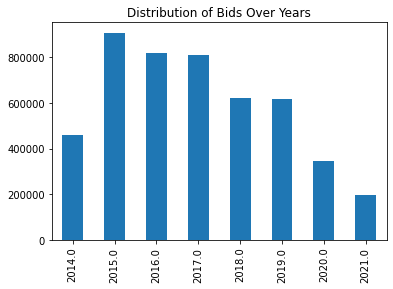

In [ ]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(1,1)
aucts = auctions[(2014 <= auctions['year']) & (auctions['year'] <= 2021)]
ax.set_xlim(2014,2022)
aucts['year'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title("Distribution of Bids Over Years")

In [ ]:
auctions[auctions['year'] == 2016]['month'].value_counts() #Distribution over months is somewhat uniform, no anomalies detected

12.0    79590
3.0     70751
4.0     61849
9.0     58401
11.0    57555
6.0     56668
2.0     53757
8.0     53460
5.0     52412
10.0    51809
7.0     45521
1.0     19119
Name: month, dtype: int64

In [ ]:
auctions_m['participant_inn'].nunique() # number of firms

535029

In [ ]:
auctions['single'] = auctions.groupby('auction_id')['participant_inn'].transform('count') == 1

In [ ]:
auctions.loc[auctions['price'] < 0, ['price']] = auctions[auctions['price'] < 0]['price'] * (-1) # replace negative price values with absolute values

In [ ]:
auctions[auctions['price'] < 0]['price']

Series([], Name: price, dtype: float64)

In [ ]:
auctions['currency'].value_counts()

RUB    700430
Name: currency, dtype: int64

In [ ]:
from datetime import datetime 
auctions['date'] = pd.to_datetime(auctions['date'], errors='coerce')
auctions['start_date'] = pd.to_datetime(auctions['start_date'], errors='coerce')
auctions['end_date'] = pd.to_datetime(auctions['end_date'], errors='coerce')
year2014 = datetime(year=2014, month=1, day=1) # create datetime for 01.01.2014
year2023 = datetime(year=2023, month=1, day=1) # create datetime for 01.01.2019
auctions = auctions[(auctions['start_date'] >= year2014) & (auctions['end_date'] < year2023)]
auctions = auctions[(auctions['max_price'] >= auctions['price']) & (auctions['price'] >= 0)]
auctions = auctions[(auctions['date'] >= auctions['start_date']) & (auctions['date'] <= auctions['end_date'])]

In [ ]:
# New features for future analysis
auctions['bid_date'] = auctions['end_date'] - auctions['date']
auctions['bid_price'] = auctions['price'] / auctions['max_price']
auctions = auctions.sort_values('start_date')
auctions['con.met'] = 1
auctions['con.met'] = (auctions.groupby(['procurer_reg_num', 'participant_inn'])['con.met'].cumsum() - 1) > 0
auctions['won'] = auctions['price'] == auctions.groupby(['auction_id'])['price'].transform('min')
auctions['won'] = (auctions['price'] == auctions.groupby(['auction_id'])['price'].transform('min')) & (auctions['date'] == auctions.groupby(['auction_id', 'won'])['date'].transform('min'))
auctions = auctions[auctions.groupby('auction_id')['won'].transform('sum') == 1]
auctions['con.win'] = auctions.groupby(['participant_inn', 'procurer_reg_num'])['won'].transform('sum') / (auctions.groupby('participant_inn')['won'].transform('sum') + 1e-6)
auctions['sel_num'] = auctions.groupby('participant_inn')['auction_id'].transform('count')
auctions['sel.period'] = (auctions.groupby('participant_inn')['date'].transform('max') - auctions.groupby('participant_inn')['date'].transform('min')).dt.days + 1
auctions['au.reserve'] = auctions['max_price'] / 500000
auctions['au.duration'] = (auctions['end_date'] - auctions['start_date']).dt.days
auctions

In [ ]:
auctions['purchase_number'].nunique() # number of auctions total

1546927

In [ ]:
auctions[auctions['single']] # number of single bidder auctions

In [ ]:
auctions['purchase_number'].nunique() # number of issuers

1537216

In [ ]:
auctions = auctions[((auctions['au.duration'] <= 24) & (auctions['end_date'].dt.year != 2020)) | ((auctions['au.duration'] <= 53) & (auctions['end_date'].dt.year == 2020))]

In [ ]:
auctions['region'].value_counts()

Moskovskaja_obl                  274678
Moskva                           208722
Sankt-Peterburg                  128217
Krasnodarskij_kraj               110343
Khanty-Mansijskij_AO-Jugra_AO     99123
                                  ...  
Chukotskij_AO                      5791
Karachaevo-Cherkesskaja_Resp       5059
Evrejskaja_Aobl                    4960
Ingushetija_Resp                   3731
Neneckij_AO                         708
Name: region, Length: 85, dtype: int64

In [ ]:
auctions['all_code'] = auctions['code_1'].map(str) + auctions['code_2'].map(str) + auctions['code_3'].map(str) + auctions['code_4'].map(str)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 <a list of 85 Text major ticklabel objects>)

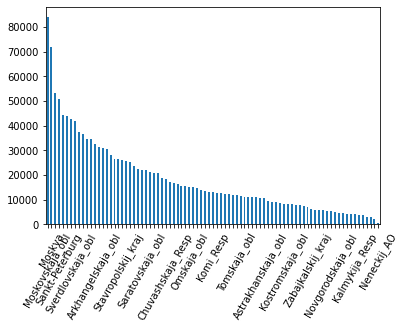

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1,1)
auctions.drop_duplicates('auction_id')['region'].value_counts().plot(kind='bar', ax=ax1)
labels = [auctions.drop_duplicates('auction_id')['region'].value_counts().index[i] if (i % 6 == 0 or i == 1 or i == 3) else "" for i in range(85)]    
ax1.set_xticklabels(labels)
plt.xticks(rotation=60)


In [ ]:
auctions.drop_duplicates('auction_id')['region'].value_counts()

Moskovskaja_obl                  83989
Moskva                           71846
Krasnodarskij_kraj               53350
Sankt-Peterburg                  50662
Khanty-Mansijskij_AO-Jugra_AO    44272
                                 ...  
Sevastopol_g                      3769
Evrejskaja_Aobl                   3045
Karachaevo-Cherkesskaja_Resp      3044
Ingushetija_Resp                  2171
Neneckij_AO                        456
Name: region, Length: 85, dtype: int64

In [ ]:
auctions[['purchase_number', 'region', 'procurer_reg_num', 'max_price',
       'currency', 'start_date', 'end_date', 'prolong_date',
       'n_commission_members', 'participant_inn', 'price', 'date',
       'is_approved', 'is_after_prolong', 'auction_id', 'single', 'bid_date',
       'bid_price', 'con.met', 'won', 'con.win', 'sel_num', 'sel.period',
       'au.reserve', 'au.duration']].isna().sum()

purchase_number               0
region                        0
procurer_reg_num              0
max_price                     0
currency                2668108
start_date                    0
end_date                      0
prolong_date            3359809
n_commission_members          0
participant_inn               0
price                         0
date                          0
is_approved                   0
is_after_prolong              0
auction_id                    0
single                        0
bid_date                      0
bid_price                     0
con.met                       0
won                           0
con.win                  310046
sel_num                       0
sel.period                    0
au.reserve                    0
au.duration                   0
dtype: int64

In [ ]:
auctions[(auctions['single'] == True)]['auction_id'].nunique()

702976

Constructing Networks

In [ ]:
gr = auctions[['participant_inn', 'auction_id']] # dataset for future graph construction
gr

,participant_inn,auction_id
0,-6330055841,603230
1,-5261068940,373737
2,-524300861251,373737
3,-5261022216,373737
4,-5260292548,373737
...,...,...
3375723,-3327330299,6007017
3375724,-3528209013,6013847
3375725,-7706196090,6076020
3375726,-7705513090,6076020


In [ ]:
import networkx as nx


In [ ]:
# We replace INN codes with negative values so that networkx would not confuse them with auction ids wwith the same value
gr['participant_inn'] = - gr['participant_inn']

In [ ]:
gr['auction_id'] = gr['auction_id'] + 1 # add 1 to avoid problems with equal auctions and participant INNs

In [ ]:
#install libraries for community detection
pip install cdlib

In [ ]:
import cdlib

In [ ]:
from cdlib import algorithms

In [ ]:
from cdlib import evaluation

In [ ]:
pip install python-louvain

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
!pip install infomap

In [ ]:
!pip install wurlitzer

In [ ]:
from cdlib import evaluation

In [ ]:
G_l = nx.Graph() #monopartite graph
G_l.add_nodes_from(gr['participant_inn'], bipartite=0)
dct  = gr.groupby('auction_id')['participant_inn'].apply(list).to_dict()
for a in dct:
  for i in range(len(dct[a])):
    for j in range(i, len(dct[a])):
      G_l.add_edge(dct[a][i], dct[a][j])
len(G_l)  

490576

In [ ]:
gr_ns = gr[gr.groupby('auction_id')['auction_id'].transform('size') > 1] # auctions without single-bidders
gr_ns

,participant_inn,auction_id
1,-5261068940,373737
2,-524300861251,373737
3,-5261022216,373737
4,-5260292548,373737
5,-7705201083,373737
...,...,...
3375718,-390401513615,5972583
3375719,-1215228078,5972583
3375720,-290121939800,5972583
3375725,-7706196090,6076020


In [ ]:
gr_ns['participant_inn'].nunique()

406372

In [ ]:
auctions[~auctions['participant_inn'].isin(gr_ns['participant_inn'])]['participant_inn'].nunique()

480787

In [ ]:
G_n = nx.Graph() # without single-bidders
G_n.add_nodes_from(gr_ns['participant_inn'], bipartite=0)
dct  = gr_ns.groupby('auction_id')['participant_inn'].apply(list).to_dict()
for a in dct:
  for i in range(len(dct[a])):
    for j in range(i, len(dct[a])):
      G_n.add_edge(dct[a][i], dct[a][j])
len(G_n)  

406372

In [ ]:
G_w = nx.Graph() # weighed graph
G_w.add_nodes_from(gr['participant_inn'], bipartite=0)
dct  = gr.groupby('auction_id')['participant_inn'].apply(list).to_dict()
for a in dct:
  for i in range(len(dct[a])):
    for j in range(i, len(dct[a])):
      if G_w.has_edge(dct[a][i], dct[a][j]):
                # we added this one before, just increase the weight by one
        G_w[dct[a][i]][dct[a][j]]['weight'] += 1
      else:
                # new edge. add with weight=1
        G_w.add_edge(dct[a][i], dct[a][j], weight=1)
len(G_w)  

490576

In [ ]:
G_nw = nx.Graph() #weighted without single
G_nw.add_nodes_from(gr_ns['participant_inn'], bipartite=0)
dct  = gr_ns.groupby('auction_id')['participant_inn'].apply(list).to_dict()
for a in dct:
  for i in range(len(dct[a])):
    for j in range(i, len(dct[a])):
      if G_nw.has_edge(dct[a][i], dct[a][j]):
                # we added this one before, just increase the weight by one
        G_nw[dct[a][i]][dct[a][j]]['weight'] += 1
      else:
                # new edge. add with weight=1
        G_nw.add_edge(dct[a][i], dct[a][j], weight=1)
len(G_nw) 

406372

In [ ]:
G_b = nx.Graph() #bipartite with all data
G_b.add_nodes_from(gr['auction_id'], bipartite=0)
G_b.add_nodes_from(gr['participant_inn'], bipartite=1)
G_b.add_edges_from([(row['auction_id'], row['participant_inn']) for idx, row in gr.iterrows()])

In [ ]:
coms_7 = algorithms.ego_networks(G_b) #some simple algorithms
coms_7

In [ ]:
len(coms_7.communities[0])

9521

In [ ]:
len(coms_7.communities)

2258149

In [ ]:
mod7 = cdlib.evaluation.newman_girvan_modularity(G_b, coms_7)
mod7

FitnessResult(min=None, max=None, score=0.1283467600748314, std=None)

In [ ]:
cond7 = cdlib.evaluation.conductance(G_b, coms_7)
cond7

FitnessResult(min=0.0, max=0.9997899380317193, score=0.7528505136190506, std=0.2909743902021932)

In [ ]:
coms_5 = algorithms.infomap_bipartite(G_b)
coms_5

In [ ]:
len(coms_14.communities)

95460

In [ ]:
len(coms_14.communities[0])

129522

In [ ]:
mod14 = cdlib.evaluation.newman_girvan_modularity(G_b, coms_14)
mod14

FitnessResult(min=None, max=None, score=0.8801974075325646, std=None)

In [ ]:
cond14 = cdlib.evaluation.conductance(G_b, coms_14)
cond14

FitnessResult(min=0.0, max=0.2335083568182919, score=0.0003470738193716909, std=0.004927499855282671)

In [ ]:
coms_42 = algorithms.lais2(G_b)
coms_42
print(len(coms_42.communities))
print(len(coms_42.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_b, coms_42))
print(cdlib.evaluation.conductance(G_b, coms_42))

Community Detection on 1 year period

In [ ]:
auctions_2017 = auctions[pd.to_datetime(auctions['date'], errors = 'coerce').dt.year == 2017] # in case we want to select only single yeasr

In [ ]:
auctions_2017['date'].max()


Timestamp('2017-12-31 16:10:00')

In [ ]:
gr_2017['participant_inn'] = - gr_2017['participant_inn']

In [ ]:
gr_2017['auction_id'] = gr_2017['auction_id'] + 1

In [ ]:
gr_2017 = auctions_2017[['participant_inn', 'auction_id']]
gr_2017

,participant_inn,auction_id
1385,2816003585,768
1386,2801002973,769
1387,2801193816,769
1388,280102545627,769
1389,2801146735,770
...,...,...
3080453,7703801991,1444225
3080491,4401125861,1444242
3080600,501604098690,1444298
3080601,7106525843,1444298


In [ ]:
G_2017 = nx.Graph()
G_2017.add_nodes_from(gr_2017['auction_id'], bipartite=0)
G_2017.add_nodes_from(gr_2017['participant_inn'], bipartite=1)
G_2017.add_edges_from([(row['auction_id'], row['participant_inn']) for idx, row in gr_2017.iterrows()])

In [ ]:
!pip uninstall cdlib
!pip uninstall networkx
!pip uninstall python-louvain
!pip uninstall community
!pip install python-louvain
!pip install networkx
!pip install cdlib

from cdlib import algorithms
import networkx as nx
#G = nx.karate_club_graph()
coms_8 = algorithms.louvain(G_2017, resolution=1., randomize=False)
print(coms_8)

In [ ]:
len(coms_8.communities)

47966

In [ ]:
len(coms_8.communities[0])

17840

In [ ]:
auctions_2017['participant_inn'] = - auctions_2017['participant_inn']
auctions_2017['auction_id'] = auctions_2017['auction_id'] + 1


In [ ]:
comsx = auctions_2017[auctions_2017['participant_inn'].isin(coms_8.communities[4]) & auctions_2017['auction_id'].isin(coms_8.communities[4])]
comsx

In [ ]:
gr_2017ns = gr_2017[gr_2017.groupby('auction_id')['auction_id'].transform('size') > 1]
gr_2017ns

In [ ]:
gr_2017.groupby('auction_id')['auction_id'].transform('size')

In [ ]:
G_f = nx.Graph()
G_f.add_nodes_from(gr_2017ns['participant_inn'], bipartite=0)
dct  = gr_2017ns.groupby('auction_id')['participant_inn'].apply(list).to_dict()
for a in dct:
  for i in range(len(dct[a])):
    for j in range(i, len(dct[a])):
      G_f.add_edge(dct[a][i], dct[a][j])
len(G_f)  

122710

In [ ]:
G_2017ns = nx.Graph()
G_2017ns.add_nodes_from(gr_2017ns['auction_id'], bipartite=0)
G_2017ns.add_nodes_from(gr_2017ns['participant_inn'], bipartite=1)
G_2017ns.add_edges_from([(row['auction_id'], row['participant_inn']) for idx, row in gr_2017ns.iterrows()])

In [ ]:
coms_9 = algorithms.louvain(G_2017ns, resolution=1., randomize=False)
print(coms_9)

In [ ]:
len(coms_9.communities)

8680

In [ ]:
len(coms_9.communities[0])

15223

In [ ]:
comsx2 = auctions_2017[auctions_2017['participant_inn'].isin(coms_9.communities[0]) & auctions_2017['auction_id'].isin(coms_9.communities[0])]
comsx2

In [ ]:
coms_10 = algorithms.louvain(G_f, resolution=1., randomize=False)
print(coms_10)

In [ ]:
len(coms_10.communities[1])

7110

In [ ]:
evaluation.newman_girvan_modularity(G_f, coms_10)

FitnessResult(min=None, max=None, score=0.8382217754142283, std=None)

In [ ]:
auctions_2017['com0'] = auctions_2017['participant_inn'].isin(coms_10.communities[0])
comsx3 = auctions_2017[auctions_2017.groupby(['auction_id'])['com0'].transform('sum') > 1]
comsx3[comsx3['com0'] == False]['participant_inn'].value_counts()

-7839399170      64
-7802843456      23
-6165167690      23
-1658111150      22
-5043031757      20
                 ..
-5001077887       1
-462001836866     1
-5033003020       1
-5002002203       1
-7726680373       1
Name: participant_inn, Length: 3689, dtype: int64

In [ ]:
auctions_2017['com1'] = auctions_2017['participant_inn'].isin(coms_10.communities[1])
comsx5 = auctions_2017[auctions_2017.groupby(['auction_id'])['com1'].transform('sum') > 1]
comsx5

,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,n_commission_members,participant_inn,price,date,is_approved,is_after_prolong,auction_id,com0,com1
4579,0835200000816001021,Kaliningradskaja_obl,8.352000e+09,140870.84,None,2016-12-30 10:00:00,2017-01-12 08:45:00,NaT,6,-7814615327,15885.60,2017-01-11 16:03:00,True,False,2231,False,True
4580,0835200000816001021,Kaliningradskaja_obl,8.352000e+09,140870.84,None,2016-12-30 10:00:00,2017-01-12 08:45:00,NaT,6,-7736674114,49506.16,2017-01-11 14:17:00,True,False,2231,False,True
10926,0334200002117000175,Irkutskaja_obl,3.342000e+09,499080.00,None,2017-10-02 12:00:00,2017-10-11 12:00:00,NaT,5,-3810314530,337040.00,2017-10-06 12:42:00,True,False,5543,False,False
10927,0334200002117000175,Irkutskaja_obl,3.342000e+09,499080.00,None,2017-10-02 12:00:00,2017-10-11 12:00:00,NaT,5,-5408130693,290012.58,2017-10-11 11:34:00,True,False,5543,False,True
10928,0334200002117000175,Irkutskaja_obl,3.342000e+09,499080.00,None,2017-10-02 12:00:00,2017-10-11 12:00:00,NaT,5,-3810053158,331452.00,2017-10-11 10:52:13,True,False,5543,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079181,0373100108117000559,Moskva,3.731001e+09,166659.32,None,2017-11-28 08:00:00,2017-12-04 09:00:00,NaT,3,-262404407141,111195.08,2017-11-30 13:06:00,True,False,1443628,False,True
3079182,0373100108117000559,Moskva,3.731001e+09,166659.32,None,2017-11-28 08:00:00,2017-12-04 09:00:00,NaT,3,-263200569202,127611.04,2017-12-01 11:30:00,True,False,1443628,False,True
3079917,0373100093917000080,Moskva,3.731001e+09,212906.67,None,2017-12-11 18:00:00,2017-12-15 12:00:00,NaT,6,-7716755750,210000.00,2017-12-14 15:50:00,True,False,1443955,False,True
3079918,0373100093917000080,Moskva,3.731001e+09,212906.67,None,2017-12-11 18:00:00,2017-12-15 12:00:00,NaT,6,-3665065194,212000.00,2017-12-14 14:53:00,True,False,1443955,False,True


In [ ]:
comsx3['participant_inn'].value_counts()

-7736035485      1541
-7710026574      1500
-7716748907       875
-7713056834       579
-7709031643       562
                 ... 
-540450372329       1
-5638054430         1
-5610075101         1
-561602189396       1
-7726680373         1
Name: participant_inn, Length: 11745, dtype: int64

In [ ]:
auctions_2017['com2'] = auctions_2017['participant_inn'].isin(coms_10.communities[2])
comsx7 = auctions_2017[auctions_2017.groupby(['auction_id'])['com2'].transform('sum') > 1]
comsx7

,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,n_commission_members,participant_inn,price,date,is_approved,is_after_prolong,auction_id,com0,com1,com2
1432,0323100013117000062,Amurskaja_obl,3.231000e+09,151078.6,None,2017-03-02 15:40:00,2017-03-20 11:15:00,NaT,6,-7721284658,109822.6,2017-03-15 15:11:00,True,False,798,False,False,True
1433,0323100013117000062,Amurskaja_obl,3.231000e+09,151078.6,None,2017-03-02 15:40:00,2017-03-20 11:15:00,NaT,6,-4345215879,119000.0,2017-03-14 11:57:00,True,False,798,False,False,True
1434,0323100013117000062,Amurskaja_obl,3.231000e+09,151078.6,None,2017-03-02 15:40:00,2017-03-20 11:15:00,NaT,6,-3329080502,143834.4,2017-03-13 10:35:00,True,False,798,False,False,True
1497,0123300001917000027,Amurskaja_obl,1.233000e+09,25200.0,None,2017-04-03 08:00:00,2017-04-07 10:00:00,NaT,5,-2812008261,18500.0,2017-04-07 09:06:00,True,False,837,False,False,True
1498,0123300001917000027,Amurskaja_obl,1.233000e+09,25200.0,None,2017-04-03 08:00:00,2017-04-07 10:00:00,NaT,5,-2801159565,13300.0,2017-04-06 11:10:00,True,False,837,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079598,0373200626217000046,Moskva,3.732006e+09,96000.0,None,2017-11-28 08:00:00,2017-12-12 09:05:00,NaT,3,-7841345341,65600.0,2017-12-07 09:20:00,True,False,1443812,False,False,True
3079599,0373200626217000046,Moskva,3.732006e+09,96000.0,None,2017-11-28 08:00:00,2017-12-12 09:05:00,NaT,3,-7729494449,78400.0,2017-12-11 13:20:00,True,False,1443812,False,False,True
3080234,0573100015917000044,Moskva,5.731000e+09,238500.0,None,2017-12-20 10:00:00,2017-12-26 12:00:00,NaT,6,-7726510942,154500.0,2017-12-26 10:50:00,True,False,1444109,False,False,True
3080235,0573100015917000044,Moskva,5.731000e+09,238500.0,None,2017-12-20 10:00:00,2017-12-26 12:00:00,NaT,6,-7723017312,155710.0,2017-12-26 11:10:00,True,False,1444109,False,False,True


In [ ]:
comsx4 = auctions_2017[auctions_2017['participant_inn'].isin(coms_10.communities[0]) & auctions_2017['auction_id'].isin(comsx3['auction_id'])]
comsx4

,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,n_commission_members,participant_inn,price,date,is_approved,is_after_prolong,auction_id,com0
1566,0123300017117000039,Amurskaja_obl,1.233000e+09,33855.53,None,2017-05-02 08:00:00,2017-05-12 09:00:00,NaT,4,-7710026574,32836.62,2017-05-02 14:05:00,True,False,862,True
1567,0123300017117000039,Amurskaja_obl,1.233000e+09,33855.53,None,2017-05-02 08:00:00,2017-05-12 09:00:00,NaT,4,-7736035485,32836.62,2017-05-02 08:05:00,True,False,862,True
1581,0123200001517000006,Amurskaja_obl,1.232000e+09,221759.17,None,2017-05-10 17:30:00,2017-05-18 14:30:00,NaT,4,-7710026574,206879.11,2017-05-15 14:27:00,True,False,868,True
1582,0123200001517000006,Amurskaja_obl,1.232000e+09,221759.17,None,2017-05-10 17:30:00,2017-05-18 14:30:00,NaT,4,-7707067683,221759.17,2017-05-10 17:42:00,True,False,868,True
1583,0123200001517000006,Amurskaja_obl,1.232000e+09,221759.17,None,2017-05-10 17:30:00,2017-05-18 14:30:00,NaT,4,-7706196090,221759.17,2017-05-12 14:00:00,True,False,868,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080338,0573100016417000022,Moskva,5.731000e+09,230161.66,None,2017-12-22 14:00:00,2017-12-29 11:00:00,NaT,5,-7710026574,192863.00,2017-12-28 13:30:00,True,False,1444168,True
3080339,0573100016417000022,Moskva,5.731000e+09,230161.66,None,2017-12-22 14:00:00,2017-12-29 11:00:00,NaT,5,-7723011286,175000.00,2017-12-26 13:20:00,True,False,1444168,True
3080340,0573100016417000022,Moskva,5.731000e+09,230161.66,None,2017-12-22 14:00:00,2017-12-29 11:00:00,NaT,5,-7744002620,184000.00,2017-12-28 11:30:00,True,False,1444168,True
3080600,0373200594917000138,Moskva,3.732006e+09,151112.00,None,2017-12-24 09:00:00,2018-01-16 09:15:00,NaT,3,-501604098690,140000.00,2017-12-28 14:10:00,True,False,1444299,True


In [ ]:
comsx6 = auctions_2017[auctions_2017['participant_inn'].isin(coms_10.communities[1]) & auctions_2017['auction_id'].isin(comsx5['auction_id'])]
comsx6

,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,n_commission_members,participant_inn,price,date,is_approved,is_after_prolong,auction_id,com0,com1
4579,0835200000816001021,Kaliningradskaja_obl,8.352000e+09,140870.84,None,2016-12-30 10:00:00,2017-01-12 08:45:00,NaT,6,-7814615327,15885.60,2017-01-11 16:03:00,True,False,2231,False,True
4580,0835200000816001021,Kaliningradskaja_obl,8.352000e+09,140870.84,None,2016-12-30 10:00:00,2017-01-12 08:45:00,NaT,6,-7736674114,49506.16,2017-01-11 14:17:00,True,False,2231,False,True
10927,0334200002117000175,Irkutskaja_obl,3.342000e+09,499080.00,None,2017-10-02 12:00:00,2017-10-11 12:00:00,NaT,5,-5408130693,290012.58,2017-10-11 11:34:00,True,False,5543,False,True
10928,0334200002117000175,Irkutskaja_obl,3.342000e+09,499080.00,None,2017-10-02 12:00:00,2017-10-11 12:00:00,NaT,5,-3810053158,331452.00,2017-10-11 10:52:13,True,False,5543,False,True
10929,0334200002117000175,Irkutskaja_obl,3.342000e+09,499080.00,None,2017-10-02 12:00:00,2017-10-11 12:00:00,NaT,5,-3849059909,319200.00,2017-10-09 10:30:01,True,False,5543,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3079181,0373100108117000559,Moskva,3.731001e+09,166659.32,None,2017-11-28 08:00:00,2017-12-04 09:00:00,NaT,3,-262404407141,111195.08,2017-11-30 13:06:00,True,False,1443628,False,True
3079182,0373100108117000559,Moskva,3.731001e+09,166659.32,None,2017-11-28 08:00:00,2017-12-04 09:00:00,NaT,3,-263200569202,127611.04,2017-12-01 11:30:00,True,False,1443628,False,True
3079917,0373100093917000080,Moskva,3.731001e+09,212906.67,None,2017-12-11 18:00:00,2017-12-15 12:00:00,NaT,6,-7716755750,210000.00,2017-12-14 15:50:00,True,False,1443955,False,True
3079918,0373100093917000080,Moskva,3.731001e+09,212906.67,None,2017-12-11 18:00:00,2017-12-15 12:00:00,NaT,6,-3665065194,212000.00,2017-12-14 14:53:00,True,False,1443955,False,True


In [ ]:
comsx3['region'].value_counts().head(20)

Moskovskaja_obl                  13877
Moskva                            9135
Tverskaja_obl                     2242
Voronezhskaja_obl                 1650
Nizhegorodskaja_obl               1556
Lipeckaja_obl                     1359
Vladimirskaja_obl                 1327
Ivanovskaja_obl                   1099
Brjanskaja_obl                    1089
Tulskaja_obl                      1059
Khanty-Mansijskij_AO-Jugra_AO     1027
Sverdlovskaja_obl                  887
Kurskaja_obl                       823
Sankt-Peterburg                    799
Belgorodskaja_obl                  796
Orlovskaja_obl                     744
Samarskaja_obl                     740
Smolenskaja_obl                    675
Jaroslavskaja_obl                  664
Novosibirskaja_obl                 628
Name: region, dtype: int64

In [ ]:
d0 = comsx3['region'].value_counts()

In [ ]:
d1 = comsx5['region'].value_counts()

In [ ]:
d2 = comsx7['region'].value_counts()
#d3 = comsx7['region'].value_counts()

Community Detection

In [ ]:
coms_44 = algorithms.louvain(G_l)
print(len(coms_44.communities))
print(len(coms_44.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_l, coms_44))
print(cdlib.evaluation.conductance(G_l, coms_44))

92592
25964
FitnessResult(min=None, max=None, score=0.7774620150230712, std=None)
FitnessResult(min=0.0, max=0.3028549825487588, score=0.0002600801472224625, std=0.005266213260282819)


In [ ]:
coms_45 = algorithms.leiden(G_l)
print(len(coms_45.communities))
print(len(coms_45.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_l, coms_45))
print(cdlib.evaluation.conductance(G_l, coms_45))

92682
31095
FitnessResult(min=None, max=None, score=0.7847343887539314, std=None)
FitnessResult(min=0.0, max=0.29587941151346697, score=0.00034115828229115024, std=0.005951667372492313)


In [ ]:
coms_46 = algorithms.louvain(G_w)
print(len(coms_46.communities))
print(len(coms_46.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_w, coms_46))
print(cdlib.evaluation.conductance(G_w, coms_46))

92695
28598
FitnessResult(min=None, max=None, score=0.8685040415715761, std=None)
FitnessResult(min=0.0, max=0.8367346938775511, score=0.000589671934917729, std=0.01186812244736315)


In [ ]:
coms_47 = algorithms.leiden(G_w)
print(len(coms_47.communities))
print(len(coms_47.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_w, coms_45))
print(cdlib.evaluation.conductance(G_w, coms_45))

92684
26756
FitnessResult(min=None, max=None, score=0.8059067995163992, std=None)
FitnessResult(min=0.0, max=0.29587941151346697, score=0.00034115828229115024, std=0.005951667372492313)


In [ ]:
G_ns = nx.Graph() # bipartite graph
G_ns.add_nodes_from(gr_ns['auction_id'], bipartite=0)
G_ns.add_nodes_from(gr_ns['participant_inn'], bipartite=1)
G_ns.add_edges_from([(row['auction_id'], row['participant_inn']) for idx, row in gr_ns.iterrows()])

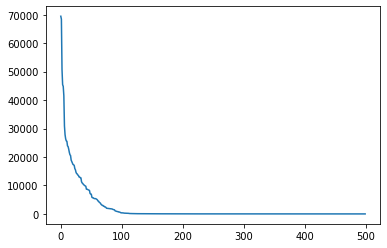

In [ ]:
import matplotlib.pyplot as plt

coms_48 = algorithms.louvain(G_ns)
lens = [len(c) for c in coms_48.communities[:500]]
plt.plot(lens)

In [ ]:
plt.plot(lens)

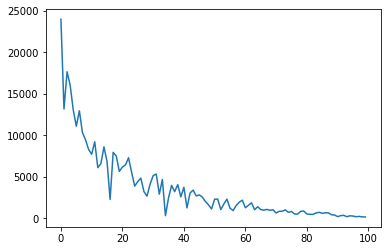

In [ ]:
import numpy as np

lens = [np.array(c.copy()) for c in coms_48.communities[:100]]
lens = [len(c[c<0]) for c in lens]
plt.plot(lens)

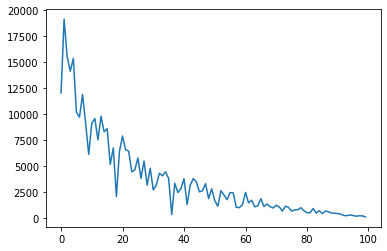

In [ ]:
import numpy as np

lens = [np.array(c.copy()) for c in coms_50.communities[:100]]
lens = [len(c[c<0]) for c in lens]
plt.plot(lens)

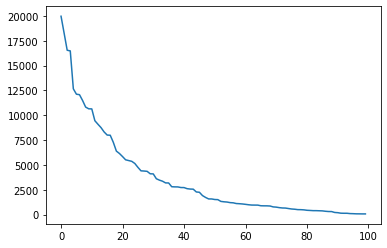

In [ ]:
import matplotlib.pyplot as plt

lens = [len(c) for c in coms_54.communities[:100]]
plt.plot(lens)

In [ ]:
len(coms_48.communities)

19287

In [ ]:
coms_48 = algorithms.louvain(G_ns)
print(len(coms_48.communities))
print(len(coms_48.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_48))
print(cdlib.evaluation.conductance(G_ns, coms_48))

19262
76782
FitnessResult(min=None, max=None, score=0.8794528317342616, std=None)
FitnessResult(min=0.0, max=0.20214580107726193, score=0.0007356088636090389, std=0.007375071288970244)


In [ ]:
import numpy as np
c1 = coms_48.communities[0]
c1 = np.array(c1.copy())
len(c1[c1 < 0]) #number of firms

23978

In [ ]:
coms_48 = algorithms.louvain(G_ns)

In [ ]:
coms_49 = algorithms.label_propagation(G_ns)
print(len(coms_49.communities))
print(len(coms_49.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_49))
print(cdlib.evaluation.conductance(G_ns, coms_49))

208235
12943
FitnessResult(min=None, max=None, score=0.6139847435844047, std=None)
FitnessResult(min=0.0, max=0.9661016949152542, score=0.42385374035854173, std=0.20079689069618625)


In [ ]:
c1 = coms_49.communities[:3]
c1 = [np.array(ci.copy()) for ci in c1] 
lens = [len(ci[ci < 0]) for ci in c1]
sum(lens)/3

2128.0

In [ ]:
c1 = coms_50.communities[:3]
c1 = [np.array(ci.copy()) for ci in c1] 
lens = [len(ci[ci < 0]) for ci in c1]
sum(lens)/3

15553.333333333334

In [ ]:
c1 = coms_48.communities[:3]
c1 = [np.array(ci.copy()) for ci in c1] 
lens = [len(ci[ci < 0]) for ci in c1]
sum(lens)/3

18268.333333333332

In [ ]:
comps = [c for c in sorted(nx.connected_components(G_ns), key=len, reverse=True)]
comps
print(len(comps))

18971


In [ ]:
comps[:50]

In [ ]:
largest_cc = max(nx.connected_components(G_ns), key=len) #largest connected component
len(largest_cc)
smallGns = G_ns.subgraph(largest_cc).copy()
smallGns

In [ ]:
!pip install leidenalg

In [ ]:
coms_50 = algorithms.leiden(smallGns)
coms_50.communities += comps[1:]
print(len(coms_50.communities))
print(len(coms_50.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_50))
print(cdlib.evaluation.conductance(smallGns, coms_50))

19330
62099
FitnessResult(min=None, max=None, score=0.8909664594958784, std=None)
FitnessResult(min=0, max=0.1941233971594503, score=0.0007797070506622545, std=0.0070742884505352)


In [ ]:
coms_l_1 = [algorithms.louvain(G_ns), algorithms.label_propagation(G_ns)]
coms_57 = algorithms.endntm(G_ns, coms_l_1)
print(len(coms_57.communities))
print(len(coms_57.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_57))
print(cdlib.evaluation.conductance(G_ns, coms_57))

19320
100645
FitnessResult(min=None, max=None, score=0.8687301408471131, std=None)
FitnessResult(min=0.0, max=0.28547671840354766, score=0.0010714587238506272, std=0.010116954103295907)


In [ ]:
print(cdlib.evaluation.conductance(G_ns, coms_56))

FitnessResult(min=0.0, max=0.9997515836542045, score=0.7546754530385772, std=0.24219862423237873)


In [ ]:
coms_l_2 = [coms_l_1[0]] + [algorithms.bimlpa(G_ns)]
coms_58 = algorithms.endntm(G_ns, coms_l_2)
print(len(coms_58.communities))
print(len(coms_58.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_58))
print(cdlib.evaluation.conductance(G_ns, coms_58))

In [ ]:
coms_l_3 = [coms_l_1[1]] + [coms_l_2[1]]
coms_59 = algorithms.endntm(G_ns, coms_l_3)
print(len(coms_59.communities))
print(len(coms_59.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_59))
print(cdlib.evaluation.conductance(G_ns, coms_59))

215106
12126
FitnessResult(min=None, max=None, score=0.5339213636896395, std=None)
FitnessResult(min=0.0, max=0.9860529986052998, score=0.3816948521511533, std=0.18230196042486424)


In [ ]:
coms_l_4 = coms_l_3 + [coms_l_1[0]]
coms_60 = algorithms.endntm(G_ns, coms_l_4)
print(len(coms_60.communities))
print(len(coms_60.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_60))
print(cdlib.evaluation.conductance(G_ns, coms_60))

20136
116436
FitnessResult(min=None, max=None, score=0.870540575149323, std=None)
FitnessResult(min=0.0, max=0.23471349478618253, score=0.0012781188739426983, std=0.010462525331576126)


In [ ]:
coms_l_5 = [algorithms.louvain(smallGns), algorithms.leiden(smallGns)]
coms_61 = algorithms.endntm(smallGns, coms_l_5)
print(len(coms_61.communities))
print(len(coms_61.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_61))
print(cdlib.evaluation.conductance(smallGns, coms_61))

375
100473
FitnessResult(min=None, max=None, score=0.8622328251899082, std=None)
FitnessResult(min=0.0019801980198019802, max=0.25002607865321813, score=0.053616277074474375, std=0.044153204551165386)


In [ ]:
coms_l_6 = [coms_l_5[0], algorithms.bimlpa(smallGns)]
coms_62 = algorithms.endntm(smallGns, coms_l_6)
print(len(coms_62.communities))
print(len(coms_62.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_62))
print(cdlib.evaluation.conductance(smallGns, coms_62))

375
100473
FitnessResult(min=None, max=None, score=0.8622328251899082, std=None)
FitnessResult(min=0.0019801980198019802, max=0.25002607865321813, score=0.053616277074474375, std=0.044153204551165386)


In [ ]:
coms_l_7 = [coms_l_6[0], algorithms.leiden(smallGns)]
coms_63 = algorithms.endntm(smallGns, coms_l_7)
print(len(coms_63.communities))
print(len(coms_63.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_63))
print(cdlib.evaluation.conductance(smallGns, coms_63))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_l_8 = [coms_l_6[1], coms_l_5[1]]
coms_64 = algorithms.endntm(smallGns, coms_l_8)
print(len(coms_64.communities))
print(len(coms_64.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_64))
print(cdlib.evaluation.conductance(smallGns, coms_64))

190615
12126
FitnessResult(min=None, max=None, score=0.5231691566461498, std=None)
FitnessResult(min=0.004878048780487805, max=0.9860529986052998, score=0.4218882462984177, std=0.14673076581807257)


In [ ]:
coms_l_9 = [coms_l_6[1], coms_l_7[1]]
coms_65 = algorithms.endntm(smallGns, coms_l_9)
print(len(coms_65.communities))
print(len(coms_65.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_65))
print(cdlib.evaluation.conductance(smallGns, coms_65))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_l_10 = [coms_l_7[1], coms_l_8[1]]
coms_66 = algorithms.endntm(smallGns, coms_l_10)
print(len(coms_66.communities))
print(len(coms_66.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_66))
print(cdlib.evaluation.conductance(smallGns, coms_66))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_l_11 = coms_l_6 + [coms_l_8[1]]
coms_67 = algorithms.endntm(smallGns, coms_l_11)
print(len(coms_67.communities))
print(len(coms_67.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_67))
print(cdlib.evaluation.conductance(smallGns, coms_67))

375
100473
FitnessResult(min=None, max=None, score=0.8622328251899082, std=None)
FitnessResult(min=0.0019801980198019802, max=0.25002607865321813, score=0.053616277074474375, std=0.044153204551165386)


In [ ]:
coms_l_12 = [coms_l_6[0]] + coms_l_10
coms_68 = algorithms.endntm(smallGns, coms_l_12)
print(len(coms_68.communities))
print(len(coms_68.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_68))
print(cdlib.evaluation.conductance(smallGns, coms_68))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_l_13 = coms_l_6 + [coms_l_7[1]]
coms_69 = algorithms.endntm(smallGns, coms_l_13)
print(len(coms_69.communities))
print(len(coms_69.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_69))
print(cdlib.evaluation.conductance(smallGns, coms_69))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_l_14 = coms_l_8 + [coms_l_7[1]]
coms_70 = algorithms.endntm(smallGns, coms_l_14)
print(len(coms_70.communities))
print(len(coms_70.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_70))
print(cdlib.evaluation.conductance(smallGns, coms_70))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_l_15 = [coms_l_5[0]] + coms_l_14
coms_71 = algorithms.endntm(smallGns, coms_l_15)
print(len(coms_71.communities))
print(len(coms_71.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(smallGns, coms_71))
print(cdlib.evaluation.conductance(smallGns, coms_71))

370
76316
FitnessResult(min=None, max=None, score=0.8735716981874931, std=None)
FitnessResult(min=0.0019801980198019802, max=0.2489144968089652, score=0.04825147699041943, std=0.04327455034329604)


In [ ]:
coms_51 = algorithms.bimlpa(G_ns)
print(len(coms_51.communities))
print(len(coms_51.communities[0]))
# print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_51))
# print(cdlib.evaluation.conductance(G_ns, coms_51))

375715
27873
FitnessResult(min=None, max=None, score=-0.0019001412307603173, std=None)


KeyboardInterrupt: ignored

In [ ]:
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_51))
print(cdlib.evaluation.conductance(G_ns, coms_51.communities))

AttributeError: ignored

In [ ]:
coms_51 = algorithms.bimlpa(G_ns)

for c in coms_51.communities.copy():

  if len(c) == 0 or c[0] > 0:
    coms_51.communities.remove(c)

print(len(coms_51.communities))
print(len(coms_51.communities[0])) 
for c in coms_51.communities.copy():
  firms = c.copy()
  for f in firms:
    c += (G_ns.neighbors(f)))

print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_51))
print(cdlib.evaluation.conductance(G_ns, coms_51))

178312
65990


TypeError: ignored

In [ ]:
print(cdlib.evaluation.newman_girvan_modularity(G_ns, coms_51))
print(cdlib.evaluation.conductance(G_ns, coms_51))

FitnessResult(min=None, max=None, score=0.53970323073857, std=None)
FitnessResult(min=0.0, max=0.9634464751958225, score=0.3918389428814992, std=0.20577722857756175)


In [ ]:
for c in coms_51.communities.copy():
  firms = c.copy()
  for f in firms:
    if isinstance(f, list):
      c.remove(f)


In [ ]:
for c in coms_51.communities.copy():
  firms = c.copy()
  for f in firms:
    c += G_ns.neighbors(f)

In [ ]:
n = 0 
for c in coms_51.communities.copy():

  if len(c) == 0 or c[0] > 0:
    coms_51.communities.remove(c)

In [ ]:
len(coms_51.communities)

237876

In [ ]:
len(coms_51.communities[0])

9516

In [ ]:
for c in coms_51.communities.copy():
  firms = c.copy()
  for f in firms:
    c.append(list(G_ns.neighbors(f)))

In [ ]:
for c in coms_51.communities.copy():
  if len(c) == 0:
    coms_51.communities.remove(c)

NameError: ignored

In [ ]:
len(coms_51.communities[0])

19032

In [ ]:
import numpy as np

coms_arr = np.array(coms_51.communities)
coms_arr = coms_arr[coms_arr[:,0] < 0]
coms_51.communities = list(coms_arr)

In [ ]:
# !pip install  igraph
!pip install karateclub

In [ ]:
coms_52 = algorithms.louvain(G_n)
print(len(coms_52.communities))
print(len(coms_52.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_n, coms_52))
print(cdlib.evaluation.conductance(G_n, coms_52))

19372
30007
FitnessResult(min=None, max=None, score=0.7701564717546542, std=None)
FitnessResult(min=0.0, max=0.30965216835028586, score=0.0016483485564248424, std=0.013158066207462498)


In [ ]:
print(cdlib.evaluation.newman_girvan_modularity(G_n, coms_52))
print(cdlib.evaluation.conductance(G_n, coms_52))

FitnessResult(min=None, max=None, score=0.7676670292486991, std=None)
FitnessResult(min=0.0, max=0.3035002007414398, score=0.001484017279659118, std=0.012437992086830666)


In [ ]:
!pip install leidenalg

     |████████████████████████████████| 1.3 MB 7.4 MB/s 


In [ ]:
coms_53 = algorithms.label_propagation(G_n)
print(len(coms_53.communities))
print(len(coms_53.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_n, coms_53))
print(cdlib.evaluation.conductance(G_n, coms_53))

406372
1
FitnessResult(min=None, max=None, score=0.1264804426435892, std=None)
FitnessResult(min=0.3333333333333333, max=0.999468791500664, score=0.6519576214923966, std=0.221441088043795)


In [ ]:
coms_54 = algorithms.louvain(G_nw)
print(len(coms_54.communities))
print(len(coms_54.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_nw, coms_54))
print(cdlib.evaluation.conductance(G_nw, coms_54))

19369
23869
FitnessResult(min=None, max=None, score=0.8666169163495577, std=None)
FitnessResult(min=0.0, max=0.4532120311919792, score=0.0021764954752295073, std=0.018631612740571592)


In [ ]:
coms_54 = algorithms.louvain(G_nw)
len(coms_54)

TypeError: ignored

In [ ]:
len(coms_54.communities)

19374

In [ ]:
import numpy as np

c1 = coms_54.communities[:3]
c1 = [np.array(ci.copy()) for ci in c1] 
lens = [len(ci[ci < 0]) for ci in c1]
sum(lens)/3

18253.333333333332

In [ ]:
len(coms_54.communities[0])

19962

In [ ]:
coms_55 = algorithms.leiden(G_nw)
print(len(coms_55.communities))
print(len(coms_55.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_nw, coms_55))
print(cdlib.evaluation.conductance(G_nw, coms_55))

19349
26224
FitnessResult(min=None, max=None, score=0.8592181371632431, std=None)
FitnessResult(min=0.0, max=0.3265983184998817, score=0.0014400271656902612, std=0.012047881379138837)


In [ ]:
c2 = coms_55.communities[:3]
c2 = [np.array(ci.copy()) for ci in c2] 
lens = [len(ci[ci < 0]) for ci in c2]
sum(lens)/3

22458.333333333332

In [ ]:
# coms_56 = algorithms.leiden(G_n)
print(len(coms_56.communities))
print(len(coms_56.communities[0]))
print(cdlib.evaluation.newman_girvan_modularity(G_n, coms_56))
print(cdlib.evaluation.conductance(G_n, coms_56))

19550
30697
FitnessResult(min=None, max=None, score=0.7773708993587839, std=None)
FitnessResult(min=0.0, max=0.28808118830388246, score=0.003144557624965719, std=0.01977688799506746)


Analysis of Communities

Distribution over regions

In [ ]:
auctions['participant_inn'] = -auctions['participant_inn']
auctions['auciton_id'] = auctions['auction_id'] + 1

In [ ]:
!pip install geopandas

/usr/local/lib/python3.7/dist-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 0
  self._schema = self.session.get_schema()
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:600: UserWarning: Empty field name at index 0
  for feature in features_lst:


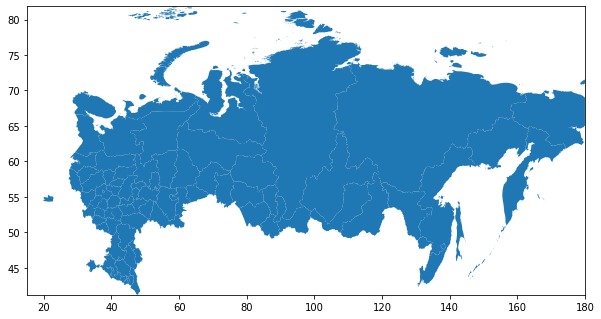

In [ ]:
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np

def load_data(url, filename, file_type):
    r = requests.get(url)
    with open(filename, 'w') as f:
        f.write(r.content.decode("utf-8"))
    with open(filename, 'r') as f:
        return file_type(f)

data = load_data(
    'https://raw.githubusercontent.com/tttdddnet/Python-Jupyter-Geo/main/geo_ru.json',
    'geo_ru.json',
     json.load)    


regs = gpd.read_file('geo_ru.json')
c = gpd.read_file('coords.gpkg')
c.index = c['region']

fig, ax = plt.subplots(figsize = (10,6))
xlim = ([15,  regs.total_bounds[2]])
ylim = ([regs.total_bounds[1],  regs.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
base = regs.plot(ax=ax)
# c.plot(markersize=c['com0'], color='yellow', ax=base)
#c.plot(markersize=c['exp'], color='red', ax=base, alpha=0.5)

In [ ]:
import pandas as pd

coord = pd.read_excel("/content/drive/MyDrive/coords.xlsx")
coord

,Unnamed: 0,id,subject,center,lat,lon,lat_radians,long_radians,type,region
0,81,81,Ненецкий АО,Нарьян-Мар,67.63869,53.00371,1.180518,0.925089,АО,Neneckij_AO
1,82,82,Ханты-Мансийский автономный округ — Югра,Ханты-Мансийск,61.00417,69.00194,1.064724,1.204311,АО,Khanty-Mansijskij_AO-Jugra_AO
2,83,83,Чукотский АО,Анадырь,64.73424,177.51030,1.129826,3.098139,АО,Chukotskij_AO
3,84,84,Ямало-Ненецкий АО,Салехард,66.53000,66.60194,1.161168,1.162423,АО,Jamalo-Neneckij_AO
4,80,80,Еврейская автономная область,Биробиджан,48.79284,132.92386,0.851596,2.319959,Аобл,Evrejskaja_Aobl
...,...,...,...,...,...,...,...,...,...,...
80,72,72,Тульская область,Тула,54.19609,37.61822,0.945900,0.656562,обл,Tulskaja_obl
81,73,73,Тюменская область,Тюмень,57.15222,65.52722,0.997494,1.143666,обл,Tjumenskaja_obl
82,74,74,Ульяновская область,Ульяновск,54.32824,48.38657,0.948207,0.844505,обл,Uljanovskaja_obl
83,75,75,Челябинская область,Челябинск,55.15402,61.42915,0.962619,1.072141,обл,Cheljabinskaja_obl


In [ ]:
population = pd.read_excel('population (1).xlsx')
population.rename(columns = {'Субъект РФ':'subject', 'Всё население':'population'}, inplace = True)

In [ ]:
coord['subject'] = coord['subject'].str.strip()
population['subject'] = population['subject'].str.strip()
cn = coord.merge(population, on=['subject'])

In [ ]:
cn.index = cn['region']
# cn['com0'] = d4
#cn.to_excel('distr.xlsx')

In [ ]:
auctions['code'] = auctions['code_1'].map(str) + auctions['code_2'].map(str)

In [ ]:
cn['com0'].sum()

3.7177899969142344e-06

In [ ]:
cn['com1'] = d1

In [ ]:
cn['population'] = cn['population'].str.split().str.join('').astype(int)
cn[['population', 'com0']].corr(method='spearman')

,population,com0
population,1.000000,0.486587
com0,0.486587,1.000000


In [ ]:
from scipy import stats
cn['com1'] = cn['com1'].fillna(0)
cn['com2'] = cn['com2'].fillna(0)
cn['com7'] = cn['com7'].fillna(0)
stats.spearmanr(cn['population'], cn['com7'])


SpearmanrResult(correlation=0.572998403064792, pvalue=1.0001999101144729e-08)

In [ ]:
cn.columns

Index(['Unnamed: 0', 'id', 'subject', 'center', 'lat', 'lon', 'lat_radians',
       'long_radians', 'type', 'region', '№', 'population', '% от общ.',
       'com0', 'com1', 'com2'],
      dtype='object')

In [ ]:
cn['com1'] = d1
cn[['population', 'com1']].corr(method='spearman')

,population,com1
population,1.000000,0.439984
com1,0.439984,1.000000


In [ ]:
from scipy.stats import chisquare
# cn['com0'] = cn['com0'].fillna(0)
# cn['com0'] = cn['com0'] / len(comsx)
# cn['exp'] = cn['% от общ.'] / 100
# chisquare(cn['com0'] * 85, f_exp=cn['exp'] * 85)
#cn.plot.bar(x='region', y='exp')
# for i in range(len(cn)):
#   print(cn['exp'][i], cn['com2'][i])

In [ ]:
from scipy.stats import chi
chi(cn['com0'] * 85, cn['exp'] * 85)

In [ ]:
max_reg = cn[cn['com0'] == cn['com0'].max()].index
max_reg

Index(['Moskovskaja_obl'], dtype='object', name='region')

In [ ]:
d4.head(20)

Moskovskaja_obl                  65006
Moskva                           56212
Samarskaja_obl                   12086
Voronezhskaja_obl                10258
Ivanovskaja_obl                  10173
Vologodskaja_obl                  8550
Vladimirskaja_obl                 7224
Sankt-Peterburg                   6353
Saratovskaja_obl                  6339
Nizhegorodskaja_obl               6227
Rostovskaja_obl                   4997
Cheljabinskaja_obl                4932
Arkhangelskaja_obl                4429
Chuvashskaja_Resp                 4302
Bashkortostan_Resp                4147
Brjanskaja_obl                    3819
Smolenskaja_obl                   3776
Khanty-Mansijskij_AO-Jugra_AO     3634
Lipeckaja_obl                     3578
Kaluzhskaja_obl                   3544
Name: region, dtype: int64

In [ ]:
cn['per_cap'] = 86010.2 * (10 ** 9) * cn['gdp_x'] / cn['population']

In [ ]:
cn['population'] = cn['population'].str.split().str.join('').astype(int)

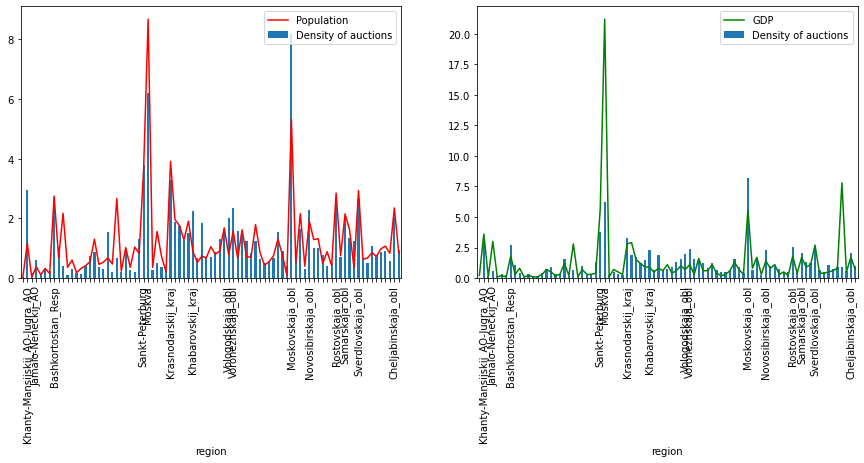

In [ ]:
import matplotlib.pyplot as plt
#correlation with population and gdp
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
# cn['auct_distr'] = cn['auct_distr'] / sum(cn['auct_distr']) * 100
cn['auct_distr'].plot(kind='bar', ax=ax1, label='Density of auctions')
cn['auct_distr'].plot(kind='bar', ax=ax2, label='Density of auctions')
cn['gdp_x'].plot(ax=ax2, color='green', label='GDP')
cn['% от общ.'].plot(ax=ax1, color='red', label='Population')
# cn['per_cap'] = cn['gdp_x'] / cn['% от общ.']
# cn['per_cap'].plot(ax=ax2, color='green')
labels = [cn['auct_distr'].index[i] if (cn['auct_distr'][i] >= 2 or i == 1 or i == 3) else "" for i in range(85)]    
ax1.set_xticklabels(labels, rotation=90)
ax2.set_xticklabels(labels, rotation=90)
ax1.legend()
ax2.legend()
# cn.plot(x='region', y=['auct_distr', 'gdp_x', '% от общ.'], kind='bar', ylim=[0,10])

In [ ]:
cn[['% от общ.', 'gdp_x', 'auct_distr']].corr()

,% от общ.,gdp_x,auct_distr
% от общ.,1.000000,0.823453,0.853029
gdp_x,0.823453,1.000000,0.680605
auct_distr,0.853029,0.680605,1.000000


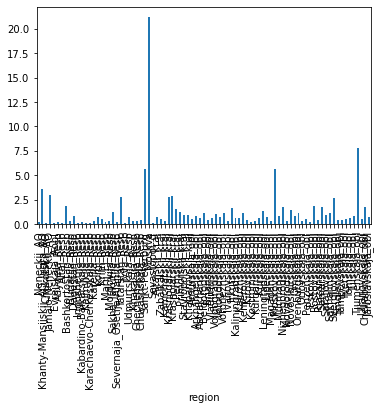

In [ ]:
cn.index = cn['region']
cn['gdp_x'].plot(kind='bar')

In [ ]:
dists = pd.read_excel("/content/drive/MyDrive/distances.xlsx")
dists

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,73,74,75,76,77,78,79,80,81,82
0,0,0.0 km,3435.7801094721726 km,1599.657705907602 km,4896.520404536892 km,622.0371664841583 km,405.1279056880681 km,307.30326667539686 km,375.5089269478323 km,161.21984245603446 km,...,1234.601305646656 km,1916.802806402944 km,1448.7908700066876 km,1827.54995105521 km,522.5591584132602 km,6651.85336629403 km,2673.9027802910946 km,2629.5067270580616 km,7328.724608408856 km,2909.2251513455863 km
1,1,3435.7801094721726 km,0.0 km,2002.552334886094 km,1487.4929425248015 km,3022.3508689575438 km,3195.0983635396024 km,3258.173154927868 km,3060.381902998044 km,3323.606686141555 km,...,2495.1271817871257 km,1652.204945314521 km,2966.9565417103704 km,3472.59523300428 km,3885.9453508204397 km,3303.3146717923114 km,2487.260531732409 km,1441.283193035203 km,5040.209872369631 km,1943.8692977489654 km
2,2,1599.657705907602 km,2002.552334886094 km,0.0 km,3380.6345806352347 km,1446.0260050955574 km,1516.7184934309807 km,1536.7418056519734 km,1249.8033465226642 km,1538.6057415241132 km,...,492.66401357169246 km,352.8265978848986 km,1046.8014098539672 km,1636.8409511903344 km,1961.1178808945551 km,5081.940812414188 km,1445.3641484622829 km,1038.0432966899639 km,5851.851588640702 km,1431.8403464188884 km
3,3,4896.520404536892 km,1487.4929425248015 km,3380.6345806352347 km,0.0 km,4507.181062314141 km,4675.060608806098 km,4734.664076506109 km,4521.5200450361235 km,4792.498258720868 km,...,3860.4876679021263 km,3030.3243686420074 km,4225.202385515035 km,4634.260469895146 km,5323.067018247451 km,1825.0699573451936 km,3381.8011291511752 km,2545.284255688002 km,4096.371173243621 km,2779.6191681180094 km
4,4,622.0371664841583 km,3022.3508689575438 km,1446.0260050955574 km,4507.181062314141 km,0.0 km,223.8934274115502 km,320.6893558499 km,450.89632709057327 km,460.8209439106497 km,...,1264.0089899153752 km,1687.4202842227567 km,1715.5879551232551 km,2218.5422046249355 km,1138.0752631367939 km,6304.681240753439 km,2765.1051630677107 km,2466.1267394535266 km,7297.525964513089 km,2868.137525917678 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,78,6651.85336629403 km,3303.3146717923114 km,5081.940812414188 km,1825.0699573451936 km,6304.681240753439 km,6461.451311491105 km,6514.606177005867 km,6280.76797443045 km,6560.186049254142 km,...,5535.705644555111 km,4744.159499694155 km,5792.447421896535 km,6092.206950759454 km,7043.053587874372 km,0.0 km,4718.271340299539 km,4129.34613616068 km,3153.721553705523 km,4160.305872267832 km
79,79,2673.9027802910946 km,2487.260531732409 km,1445.3641484622829 km,3381.8011291511752 km,2765.1051630677107 km,2762.061759744472 km,2744.813415888783 km,2428.553110276136 km,2685.777180718973 km,...,1503.0292039233523 km,1459.0821857097005 km,1297.1270263495726 km,1396.3782213019458 km,2809.285109938304 km,4718.271340299539 km,0.0 km,1064.5883645128058 km,4677.01686456942 km,602.5781408218878 km
80,80,2629.5067270580616 km,1441.283193035203 km,1038.0432966899639 km,2545.284255688002 km,2466.1267394535266 km,2551.7948982178436 km,2574.426980564037 km,2286.7096518233398 km,2575.3552781564067 km,...,1428.4409157851626 km,788.9704624453982 km,1685.6384815915728 km,2100.226790537304 km,2950.4397278595843 km,4129.34613616068 km,1064.5883645128058 km,0.0 km,4855.826660836337 km,627.1429669436327 km
81,81,7328.724608408856 km,5040.209872369631 km,5851.851588640702 km,4096.371173243621 km,7297.525964513089 km,7350.077658129388 km,7353.128348716131 km,7042.561392766328 km,7318.936380354796 km,...,6105.726852451037 km,5644.489404231029 km,5969.484642604195 km,5905.900022416976 km,7484.933770680173 km,3153.721553705523 km,4677.01686456942 km,4855.826660836337 km,0.0 km,4437.105852571108 km


In [ ]:
import numpy as np 

coord[['lat_radians','long_radians']] = (
    np.radians(coord.loc[:,['lat','lon']])
)
coord

,Unnamed: 0,id,subject,center,lat,lon,lat_radians,long_radians,type,region
0,81,81,Ненецкий АО,Нарьян-Мар,67.63869,53.00371,1.180518,0.925089,АО,Neneckij_AO
1,82,82,Ханты-Мансийский автономный округ — Югра,Ханты-Мансийск,61.00417,69.00194,1.064724,1.204311,АО,Khanty-Mansijskij_AO-Jugra_AO
2,83,83,Чукотский АО,Анадырь,64.73424,177.51030,1.129826,3.098139,АО,Chukotskij_AO
3,84,84,Ямало-Ненецкий АО,Салехард,66.53000,66.60194,1.161168,1.162423,АО,Jamalo-Neneckij_AO
4,80,80,Еврейская автономная область,Биробиджан,48.79284,132.92386,0.851596,2.319959,Аобл,Evrejskaja_Aobl
...,...,...,...,...,...,...,...,...,...,...
80,72,72,Тульская область,Тула,54.19609,37.61822,0.945900,0.656562,обл,Tulskaja_obl
81,73,73,Тюменская область,Тюмень,57.15222,65.52722,0.997494,1.143666,обл,Tjumenskaja_obl
82,74,74,Ульяновская область,Ульяновск,54.32824,48.38657,0.948207,0.844505,обл,Uljanovskaja_obl
83,75,75,Челябинская область,Челябинск,55.15402,61.42915,0.962619,1.072141,обл,Cheljabinskaja_obl


In [ ]:
from sklearn import neighbors

dist = neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
    (coord[['lat_radians','long_radians']],
     coord[['lat_radians','long_radians']])*6371
)
dist_matrix

array([[   0.        , 1061.15831977, 4658.74427164, ..., 1499.84751457,
        1455.75788285, 1293.63200438],
       [1061.15831977,    0.        , 4837.6194572 , ..., 1424.18196866,
         787.1989801 , 1679.72882416],
       [4658.74427164, 4837.6194572 ,    0.        , ..., 6084.32690052,
        5624.52845446, 5947.79709669],
       ...,
       [1499.84751457, 1424.18196866, 6084.32690052, ...,    0.        ,
         840.96936805,  643.68304518],
       [1455.75788285,  787.1989801 , 5624.52845446, ...,  840.96936805,
           0.        , 1348.8285032 ],
       [1293.63200438, 1679.72882416, 5947.79709669, ...,  643.68304518,
        1348.8285032 ,    0.        ]])

In [ ]:
df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=coord['region'], 
                 columns=coord['region'])
)
df_dist_matrix['Neneckij_AO']['Chukotskij_AO']

4658.744271637316

In [ ]:
import numpy as np

df_dist_matrix = df_dist_matrix / np.linalg.norm(df_dist_matrix)

In [ ]:
df_dist_matrix

region,Neneckij_AO,Khanty-Mansijskij_AO-Jugra_AO,Chukotskij_AO,Jamalo-Neneckij_AO,Evrejskaja_Aobl,Adygeja_Resp,Altaj_Resp,Bashkortostan_Resp,Burjatija_Resp,Dagestan_Resp,...,Sverdlovskaja_obl,Smolenskaja_obl,Tambovskaja_obl,Tverskaja_obl,Tomskaja_obl,Tulskaja_obl,Tjumenskaja_obl,Uljanovskaja_obl,Cheljabinskaja_obl,Jaroslavskaja_obl
region,,,,,,,,,,,,,,,,,,,,,
Neneckij_AO,0.000000,0.004066,0.017852,0.002300,0.018023,0.010231,0.009505,0.005527,0.012918,0.010583,...,0.004829,0.006893,0.006781,0.005670,0.007807,0.006513,0.005085,0.005747,0.005578,0.004957
Khanty-Mansijskij_AO-Jugra_AO,0.004066,0.000000,0.018537,0.002397,0.015774,0.010055,0.005509,0.003967,0.009723,0.009436,...,0.002553,0.008647,0.007245,0.007403,0.004004,0.007638,0.001808,0.005457,0.003016,0.006436
Chukotskij_AO,0.017852,0.018537,0.000000,0.016936,0.012051,0.027997,0.019248,0.022344,0.015645,0.027881,...,0.021022,0.024536,0.024608,0.023412,0.017876,0.024350,0.020322,0.023314,0.021552,0.022791
Jamalo-Neneckij_AO,0.002300,0.002397,0.016936,0.000000,0.015893,0.011127,0.007431,0.005474,0.010620,0.010975,...,0.004293,0.008605,0.007887,0.007329,0.005632,0.007927,0.004001,0.006406,0.004960,0.006462
Evrejskaja_Aobl,0.018023,0.015774,0.012051,0.015893,0.000000,0.025416,0.012619,0.019412,0.006972,0.024091,...,0.018033,0.024337,0.022990,0.023065,0.012543,0.023406,0.016916,0.021146,0.018122,0.022125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tulskaja_obl,0.006513,0.007638,0.024350,0.007927,0.023406,0.004143,0.012157,0.004537,0.017222,0.005521,...,0.005632,0.001403,0.001153,0.001208,0.011286,0.000000,0.006773,0.002678,0.005852,0.001559
Tjumenskaja_obl,0.005085,0.001808,0.020322,0.004001,0.016916,0.008589,0.005476,0.002498,0.010480,0.007747,...,0.001147,0.007967,0.006150,0.006821,0.004527,0.006773,0.000000,0.004271,0.001292,0.005859
Uljanovskaja_obl,0.005747,0.005457,0.023314,0.006406,0.021146,0.004727,0.009530,0.001882,0.014745,0.004843,...,0.003129,0.004035,0.001884,0.003188,0.008791,0.002678,0.004271,0.000000,0.003222,0.002466


In [ ]:
freq_r = comsx3['region'].value_counts().idxmax()
freq_r

reg_n = comsx3['region'].value_counts().to_dict()

mean_d = 0
for reg1 in reg_n:
    dist = df_dist_matrix[freq_r][reg1]
    #print(dist)
    dist = dist * (reg_n[freq_r] * reg_n[reg1])
    mean_d += dist 
   # print(mean_d)

mean_d = mean_d * 2/ (len(comsx3) * (len(comsx3)-1))
mean_d

292.40432189989

In [ ]:
df_dist_matrix[max_reg].sort_values(by=max_reg[0]).head(30)

region,Moskovskaja_obl
region,
Moskovskaja_obl,0.000000
Moskva,0.000000
Kaluzhskaja_obl,160.447408
Tverskaja_obl,162.225846
Tulskaja_obl,173.033844
Vladimirskaja_obl,178.352505
Rjazanskaja_obl,181.709681
Ivanovskaja_obl,248.678404
Jaroslavskaja_obl,250.177997


In [ ]:
set(comsx['region'].value_counts().head(20).index)

{'Arkhangelskaja_obl',
 'Bashkortostan_Resp',
 'Brjanskaja_obl',
 'Cheljabinskaja_obl',
 'Chuvashskaja_Resp',
 'Ivanovskaja_obl',
 'Kaluzhskaja_obl',
 'Khanty-Mansijskij_AO-Jugra_AO',
 'Lipeckaja_obl',
 'Moskovskaja_obl',
 'Moskva',
 'Nizhegorodskaja_obl',
 'Rostovskaja_obl',
 'Samarskaja_obl',
 'Sankt-Peterburg',
 'Saratovskaja_obl',
 'Smolenskaja_obl',
 'Vladimirskaja_obl',
 'Vologodskaja_obl',
 'Voronezhskaja_obl'}

In [ ]:
neighbors = pd.read_csv('query.csv')
neighbors = neighbors[['subjectLabel', 'subjectsLabel']]
for r in neighbors['subjectLabel'].unique():
  if r not in population['subject'].unique():
    print(r)
print('  ')
for r in population['subject'].unique():
  if r not in neighbors['subjectLabel'].unique():
    print(r)

Тыва
Карелия
Адыгея
Калмыкия
Дагестан
Чечня
Ингушетия
Республика Северная Осетия-Алания
Кабардино-Балкария
Карачаево-Черкесия
Мордовия
Удмуртия
Марий Эл
Чувашия
Татарстан
Хакасия
Якутия
Бурятия
Ненецкий автономный округ
Ямало-Ненецкий автономный округ
Чукотский автономный округ
  
Республика Татарстан
Республика Дагестан
Чеченская Республика
Удмуртская Республика
Чувашская Республика
Республика Саха (Якутия)
Республика Бурятия
Кабардино-Балкарская Республика
Республика Мордовия
Республика Северная Осетия — Алания
Республика Марий Эл
Республика Карелия
Ямало-Ненецкий АО
Республика Хакасия
Республика Ингушетия
Республика Адыгея
Карачаево-Черкесская Республика
Республика Тыва
Республика Калмыкия
Чукотский АО
Ненецкий АО


In [ ]:
replaces = {'Тыва': 'Республика Тыва', 'Карелия': 'Республика Карелия', 'Адыгея': 'Республика Адыгея', 'Калмыкия': 'Республика Калмыкия', 
           'Дагестан': 'Республика Дагестан', 'Чечня': 'Чеченская Республика', 'Ингушетия': 'Республика Ингушетия', 'Республика Северная Осетия-Алания': 'Республика Северная Осетия — Алания',
            'Кабардино-Балкария': 'Кабардино-Балкарская Республика', 'Карачаево-Черкесия': 'Карачаево-Черкесская Республика', 'Мордовия': 'Республика Мордовия',
            'Удмуртия': 'Удмуртская Республика', 'Марий Эл': 'Республика Марий Эл', 'Чувашия': 'Чувашская Республика', 'Татарстан': 'Республика Татарстан',
            'Хакасия': 'Республика Хакасия', 'Якутия': 'Республика Саха (Якутия)', 'Бурятия': 'Республика Бурятия'
            }
neighbors.replace(replaces, inplace=True)
neighbors.replace('автономный округ', 'АО', inplace=True, regex=True)
neighbors.replace('Ханты-Мансийский АО — Югра', 'Ханты-Мансийский автономный округ — Югра', inplace=True)

In [ ]:
cn.index = cn['subject']
translit = cn['region'].to_dict()
cn.index = cn['region']

In [ ]:
neighbors['subjectsLabel'] = neighbors['subjectsLabel'].fillna(neighbors['subjectLabel'])

In [ ]:
neighbors.replace(translit, inplace=True)
neighbors = neighbors.fillna(neighbors['subjectLabel'])

In [ ]:
neighbors2 = neighbors.groupby('subjectLabel')['subjectsLabel'].agg('unique')
neighbors2 = neighbors2.reset_index()
neighbors2.index = neighbors2['subjectLabel']

In [ ]:
neighbors2.head()

,subjectLabel,subjectsLabel
subjectLabel,,
Adygeja_Resp,Adygeja_Resp,"[Adygeja_Resp, Krasnodarskij_kraj]"
Altaj_Resp,Altaj_Resp,"[Altaj_Resp, Tyva_Resp, Altajskij_kraj, Kemero..."
Altajskij_kraj,Altajskij_kraj,"[Altajskij_kraj, Novosibirskaja_obl, Altaj_Res..."
Amurskaja_obl,Amurskaja_obl,"[Amurskaja_obl, Sakha_Jakutija_Resp, Zabajkals..."
Arkhangelskaja_obl,Arkhangelskaja_obl,"[Arkhangelskaja_obl, Murmanskaja_obl, Karelija..."


In [ ]:
import numpy as np
from tqdm import tqdm

def count_anova(df, coms, features):
  '''Update df adding number of community and if noncompetitive'''
  df['com_n'] = 0
  df['sus'] = False
  vals = {feature:[] for feature in features}
  inp = {}
  df_1, df_2 = pd.DataFrame(columns=auctions.columns), pd.DataFrame(columns=auctions.columns)
  for i,com in enumerate(tqdm(coms)):
    df['com'] = df['participant_inn'].isin(com)
    comsx = df[(df.groupby(['auction_id'])['com'].transform('prod') == 1) ]
    df.loc[df['com'], ['com_n']] = i
    if comsx['single'].mean() > 0.5:
      df.loc[df['com'], ['sus']] = True
  return df

In [ ]:
updated_auctions = count_anova(auctions, coms_54.communities, ['single'])
updated_auctions.to_csv("/content/drive/MyDrive/Maria Mitrankova/updated.csv")

100%|██████████| 19376/19376 [3:53:54<00:00,  1.38it/s]


In [ ]:
import pandas as pd
auctions = pd.read_csv("/content/drive/MyDrive/Maria Mitrankova/updated.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,8,22,25,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
def describe_comm(df, com_n, plot=False):

  df['com'] = df['com_n'] == com_n
  comsx = df[df.groupby(['auction_id'])['com'].transform('sum') > 1]
  d = comsx['region'].value_counts()
  freq_r = comsx['region'].value_counts().idxmax()
  regs = d[d > len(comsx) * 0.02].index.to_list()
 # print(d)
  for i in range(len(regs)):
    flag = False
    if len(regs) == 1:
      flag = True
    for j in range(len(regs)):
      if regs[i] == regs[j]:
        continue
      if regs[j] == 'Sankt-Peterburg':
        reg = 'Leningradskaja_obl'
      elif regs[j] == 'Moskva':
        reg = 'Moskovskaja_obl'
      elif regs[j] == 'Sevastopol_g':
        reg = 'Krim_Resp'
      elif regs[j] == 'Adygeja_Resp':
        reg = 'Krasnodarskij_kraj'
      else:
        reg = regs[j]
      neighbs = neighbors2['subjectsLabel'].loc[reg]
      if regs[i] != regs[j] and regs[i] in neighbs:
        flag = True
    if not flag:
   #   print(regs[i])
      break
  cn['com'] = d
  cn['com'] = cn['com'].fillna(0)
  cn['com'] = cn['com'] / len(comsx)  
  cn['exp'] = cn['% от общ.'] / 100
  pv = chisquare(cn['com'] * 85, f_exp=cn['exp'] * 85)[1]
 # print('p-value', pv)
  mtype = ''
  if pv < 0.01 and flag:
  #  print('regional')
    mtype = 'regional'
    regs = d[d > len(comsx) * 0.01].index.to_list()
  #  print(regs)

  else:
    mtype = 'federal'
    regs = []
  #  print('federal')
  
  codes = (comsx['code'].map(str)).value_counts()
 # print(codes)
  codes = codes[codes > len(comsx) * 0.05].index.to_list()
#  print(codes)
  if plot:
    c['com'] = d
    regions = gpd.read_file('geo_ru.json')
    fig, ax = plt.subplots(figsize = (10,6))
    xlim = ([15,  regions.total_bounds[2]])
    ylim = ([regions.total_bounds[1],  regions.total_bounds[3]])

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    base = regions.plot(ax=ax)
    c.plot(markersize=c['com']/50, color='yellow', ax=base)

    fig, ax1 = plt.subplots(1,1)
    (cn['com'] / sum(cn['com']) * 100).plot(kind='bar', ax=ax1, label='Density of auctions')
    labels = [cn['region'][i] if (cn['com'][i] / sum(cn['com'])) > 0.038 else "" for i in range(85)]    
    cn['% от общ.'].plot(ax=ax1, color='red', label='Population')
    ax1.set_xticklabels(labels, rotation=90)
    ax1.legend()
    # ax1.set_title('Actual distribution of community')
  return mtype, regs, codes


('federal', [], ['nannan', '18.012.0'])

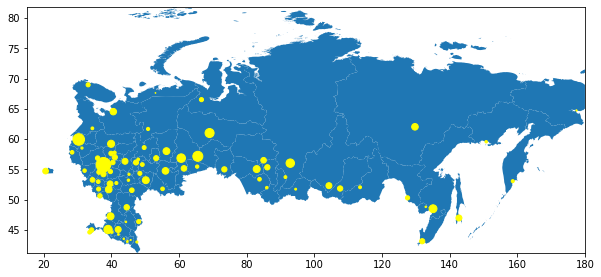

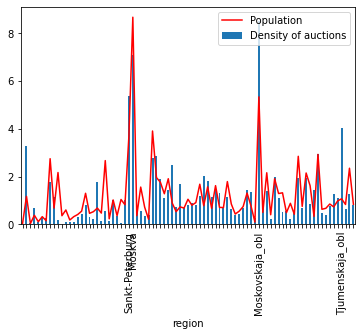

In [ ]:
describe_comm(auctions, 1, plot=True)

In [ ]:
auctions = auctions[['Unnamed: 0', 'purchase_number', 'region', 'procurer_reg_num',
       'max_price', 'currency', 'start_date', 'end_date', 'prolong_date',
       'n_commission_members', 'participant_inn', 'price', 'date',
       'is_approved', 'is_after_prolong', 'auction_id', 'Unnamed: 0.1',
       'code_1', 'code_2', 'code_3', 'code_4', 'name', 'object','single', 'bid_date',
       'bid_price', 'con.met', 'won', 'con.win', 'sel_num', 'sel.period',
       'au.reserve', 'au.duration', 'auciton_id', 'com_n', 'sus', 'com']]

In [ ]:
new_objs = pd.read_csv("/content/drive/MyDrive/Maria Mitrankova/auctions_objs2.csv")
new_objs = new_objs.drop_duplicates(['purchase_number'])
new_objs.i
auctions_t = auctions.merge(new_objs, on=['purchase_number'], how='left', suffixes=('', '_x'))
auctions_t.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['Unnamed: 0', 'purchase_number', 'region', 'procurer_reg_num',
       'max_price', 'currency', 'start_date', 'end_date', 'prolong_date',
       'n_commission_members', 'participant_inn', 'price', 'date',
       'is_approved', 'is_after_prolong', 'auction_id', 'Unnamed: 0.1',
       'code_1', 'code_2', 'code_3', 'code_4', 'name', 'object', 'single',
       'bid_date', 'bid_price', 'con.met', 'won', 'con.win', 'sel_num',
       'sel.period', 'au.reserve', 'au.duration', 'auciton_id', 'com_n', 'sus',
       'com', 'Unnamed: 0_x', 'auction_id_x', 'procurer_reg_num_x',
       'start_date_x', 'code_1_x', 'code_2_x', 'code_3_x', 'code_4_x',
       'if_okpd2', 'name_x', 'region_id'],
      dtype='object')

In [ ]:
auctions = auctions_t

In [ ]:
# auctions['code_1'] = auctions['code_1'].fillna(auctions['code_1_y'])
# auctions['code_2'] = auctions['code_2'].fillna(auctions['code_2_y'])
# auctions['code_3'] = auctions['code_3'].fillna(auctions['code_3_y'])
# auctions['code_4'] = auctions['code_4'].fillna(auctions['code_4_y'])
# auctions['name'] = auctions['name'].fillna(auctions['name_y'])
auctions['code_1'] = auctions['code_1'].fillna(auctions['code_1_x'])
auctions['code_2'] = auctions['code_2'].fillna(auctions['code_2_x'])
auctions['code_3'] = auctions['code_3'].fillna(auctions['code_3_x'])
auctions['code_4'] = auctions['code_4'].fillna(auctions['code_4_x'])
auctions['name'] = auctions['name'].fillna(auctions['name_x'])

In [ ]:
auctions[~auctions['code_1'].isna()]

In [ ]:
auctions.columns

Index(['Unnamed: 0', 'purchase_number', 'region', 'procurer_reg_num',
       'max_price', 'currency', 'start_date', 'end_date', 'prolong_date',
       'n_commission_members', 'participant_inn', 'price', 'date',
       'is_approved', 'is_after_prolong', 'auction_id', 'Unnamed: 0.1',
       'code_1', 'code_2', 'code_3', 'code_4', 'name', 'object', 'single',
       'bid_date', 'bid_price', 'con.met', 'won', 'con.win', 'sel_num',
       'sel.period', 'au.reserve', 'au.duration', 'auciton_id', 'com_n', 'sus',
       'com', 'Unnamed: 0_x', 'auction_id_x', 'procurer_reg_num_x',
       'start_date_x', 'code_1_x', 'code_2_x', 'code_3_x', 'code_4_x',
       'if_okpd2', 'name_x', 'region_id'],
      dtype='object')

In [ ]:
auctions_t = auctions_m.merge(auctions_new_obj, on=['purchase_number'], how='left', suffixes=('', '_y'))
auctions_t.columns

In [ ]:
new_objs[new_objs['purchase_number'].isin(auctions['purchase_number'])]

,Unnamed: 0,auction_id,purchase_number,procurer_reg_num,start_date,code_1,code_2,code_3,code_4,if_okpd2,name,region_id
0,0,199.0,2.231000e+17,2.231000e+09,2014-02-26 10:00:00,21.0,12.0,14.0,190.0,False,"Бумага для печати, не включенная в другие груп...",NaN
3,3,733.0,3.232000e+17,3.232000e+09,2014-04-11 17:00:00,15.0,51.0,40.0,113.0,False,"Творог с массовой долей жира от 4,0 % до 18,0 %",NaN
4,4,733.0,3.232000e+17,3.232000e+09,2014-04-11 17:00:00,15.0,51.0,52.0,141.0,False,Кефир без пищевых продуктов и пищевых добавок,NaN
5,5,733.0,3.232000e+17,3.232000e+09,2014-04-11 17:00:00,15.0,51.0,52.0,170.0,False,Ряженка,NaN
6,6,733.0,3.232000e+17,3.232000e+09,2014-04-11 17:00:00,15.0,51.0,52.0,232.0,False,"Сметана с массовой долей жира от 15,0 % до 34,0 %",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3087070,20186,14060.0,3.472000e+17,NaN,NaN,10.0,89.0,19.0,130.0,True,"Продукты пищевые из муки, крупы, крахмала (кро...",1.0
3087071,20187,14061.0,3.472000e+17,NaN,NaN,1.0,12.0,13.0,119.0,False,Капуста прочая,1.0
3087072,20188,14062.0,3.472000e+17,NaN,NaN,10.0,84.0,30.0,140.0,True,Соль пищевая молотая,1.0
3087073,20189,14063.0,3.472000e+17,NaN,NaN,10.0,39.0,16.0,0.0,True,"Горох, консервированный без уксуса или уксусно...",1.0


In [ ]:
auctions['com_n'].max()

19375

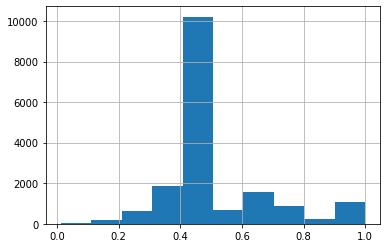

In [ ]:
auctions[~auctions['sus']].groupby(['com_n'])['con.win'].mean().hist()

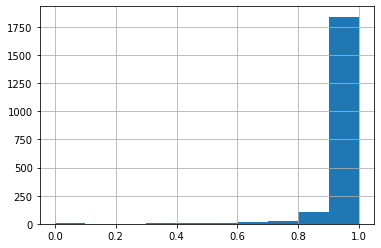

In [ ]:
auctions[auctions['sus'] & auctions['single']].groupby(['com_n'])['bid_price'].mean().hist()

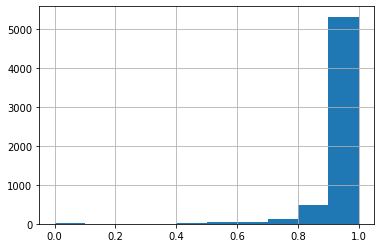

In [ ]:
auctions[(~auctions['sus']) & (auctions['single'])].groupby(['com_n'])['bid_price'].mean().hist()

In [ ]:
auctions[~auctions['sus']].groupby(['com_n'])['bid_date'].mean().mean()

Timedelta('1 days 23:33:00.222174335')

In [ ]:
print(auctions[auctions['sus']].groupby(['com_n'])['bid_price'].mean().mean())
auctions[~auctions['sus']].groupby(['com_n'])['bid_price'].mean().mean()

0.9547951841367864


0.9479528613306836

In [ ]:
print(auctions[auctions['sus']].groupby(['com_n'])['con.win'].mean().mean())
auctions[~auctions['sus']].groupby(['com_n'])['con.win'].mean().mean()

0.6200767611890413


0.5334270000060952

In [ ]:
print(auctions[auctions['sus']].groupby(['com_n'])['sel_num'].mean().mean())
auctions[~auctions['sus']].groupby(['com_n'])['sel_num'].mean().mean()

7.530606275204799


3.029342953903483

In [ ]:
print(auctions[auctions['sus']].groupby(['com_n'])['au.duration'].mean().mean())
auctions[~auctions['sus']].groupby(['com_n'])['au.duration'].mean().mean()

7.934988513605171


7.750193305727324

In [ ]:
import pandas as pd

auctions = pd.read_csv("/content/drive/MyDrive/Maria Mitrankova/counted.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,23,26,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from tqdm import tqdm
# Calculate Degree Centralities
centralities = []
for i in tqdm(range(19376)):
  firms = auctions[(auctions['com_n'] == i)]['participant_inn'].unique().tolist()
  G = G_nw.subgraph(firms)
  c = nx.degree_centrality(G)
  centralities.append(c)

100%|██████████| 19376/19376 [02:34<00:00, 125.11it/s]


In [ ]:
centralities_cl = []
# Calculate eigenvector centralities
for i in tqdm(range(19376)):
  firms = auctions[(auctions['com_n'] == i)]['participant_inn'].unique().tolist()
  G = G_nw.subgraph(firms)
  c = nx.closeness_centrality(G)
  centralities_cl.append(c)

  0%|          | 1/19376 [5:02:35<97714:27:07, 18155.98s/it]

In [ ]:
import numpy as np

centrals = []
for m in centralities:
  central = []
  for key in m:
    central.append(m[key])
  central = np.array(central)
  centrals.append(central)

centrals = np.array(centrals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
means = []
for c in centrals:
  means.append(c.mean())

In [ ]:
centralities = np.array(centralities)

In [ ]:
# winning rate
auctions['win_rate'] = auctions.groupby('participant_inn')['won'].transform('mean')
auctions['win_rate']

0          0.476684
1          0.617021
2          0.476190
3          0.330739
4          0.900000
             ...   
3243236    0.556701
3243237    0.523077
3243238    0.269916
3243239    0.319728
3243240    0.732984
Name: win_rate, Length: 3243241, dtype: float64

In [ ]:
global_d = {}
for c in centralities:
  global_d.update(c)

In [ ]:
auctions['d_centrality'] = auctions['participant_inn'].apply(lambda x: global_d.get(x))
auctions

,Unnamed: 0,Unnamed: 0.1,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,...,one_com,cv_price,cv_bidding,code,stable,cartel,coherent,exclusive,win_rate,d_centrality
0,1,829607,3.323003e+17,Nizhegorodskaja_obl,3.323003e+09,95690.00,NaN,2014-02-10 08:00:00,2014-02-13 16:30:00,NaN,...,True,NaN,NaN,nannan,True,False,False,False,0.476684,0.005502
1,2,829606,3.323003e+17,Nizhegorodskaja_obl,3.323003e+09,95690.00,NaN,2014-02-10 08:00:00,2014-02-13 16:30:00,NaN,...,True,6.269499,0.000039,nannan,True,False,False,False,0.617021,0.002113
2,3,829608,3.323003e+17,Nizhegorodskaja_obl,3.323003e+09,95690.00,NaN,2014-02-10 08:00:00,2014-02-13 16:30:00,NaN,...,True,NaN,NaN,nannan,True,False,False,False,0.476190,0.001937
3,4,829609,3.323003e+17,Nizhegorodskaja_obl,3.323003e+09,95690.00,NaN,2014-02-10 08:00:00,2014-02-13 16:30:00,NaN,...,True,NaN,NaN,nannan,True,False,False,False,0.330739,0.015098
4,5,829610,3.323003e+17,Nizhegorodskaja_obl,3.323003e+09,95690.00,NaN,2014-02-10 08:00:00,2014-02-13 16:30:00,NaN,...,True,NaN,NaN,nannan,True,False,False,False,0.900000,0.000308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243236,3375723,4273650,3.283000e+17,Vladimirskaja_obl,3.283000e+09,1288259.67,RUB,2021-12-31 12:32:29,2022-01-14 13:00:00,NaN,...,True,1.225696,0.000008,21.020.0,True,False,False,False,0.556701,0.009342
3243237,3375724,4711880,3.303000e+17,Vologodskaja_obl,3.303000e+09,258615.57,RUB,2021-12-31 13:20:28,2022-01-17 09:00:00,NaN,...,True,1.225696,0.000008,21.020.0,True,False,False,False,0.523077,0.007526
3243238,3375725,3202809,3.731001e+17,Moskva,3.731001e+09,500000.00,RUB,2021-12-31 14:08:08,2022-01-14 11:00:00,NaN,...,True,NaN,NaN,65.012.0,True,False,False,False,0.269916,0.385321
3243239,3375726,3202808,3.731001e+17,Moskva,3.731001e+09,500000.00,RUB,2021-12-31 14:08:08,2022-01-14 11:00:00,NaN,...,True,1.085352,0.000011,65.012.0,True,False,False,False,0.319728,0.134557


In [ ]:
mean_c = auctions.groupby('participant_inn')['d_centrality'].mean().mean()
mean_wr = auctions.groupby('participant_inn')['win_rate'].mean().mean()

In [ ]:
print(auctions[(auctions['win_rate'] > mean_wr)  & (auctions['ev_centrality'] > mean_c) & auctions['stable']]['participant_inn'].nunique()/auctions[auctions['stable']]['participant_inn'].nunique())
print(auctions[(auctions['win_rate'] > mean_wr)  & (auctions['ev_centrality'] > mean_c) & (~auctions['stable'])]['participant_inn'].nunique()/auctions[~auctions['stable']]['participant_inn'].nunique())

0.04636844761325552
0.3857865478038764


In [ ]:
auctions['high_win'] = (auctions['win_rate'] > mean_wr)  & (auctions['d_centrality'] > mean_c)
auctions[auctions['high_win']]

,Unnamed: 0,Unnamed: 0.1,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,...,code,stable,cartel,coherent,exclusive,win_rate,d_centrality,high_win,ev_centrality,high_win_ev
18,21,2030068,8.101000e+17,Severnaja_Osetija-Alanija_Resp,8.101000e+09,235232.91,NaN,2014-04-08 00:00:00,2014-04-17 18:00:00,NaN,...,nannan,False,False,False,True,1.000000,2.000000,True,0.707107,True
28,32,1658429,3.023000e+17,Burjatija_Resp,3.023000e+09,248650.99,NaN,2014-04-21 08:00:00,2014-04-24 17:00:00,NaN,...,nannan,True,False,True,True,1.000000,3.000000,True,0.707107,True
46,51,1383832,3.583000e+17,Rostovskaja_obl,3.583000e+09,4140.80,NaN,2014-05-08 09:00:00,2014-05-15 17:00:00,NaN,...,nannan,True,False,True,True,1.000000,3.000000,True,0.707107,True
83,94,444862,1.048300e+18,Moskovskaja_obl,1.048300e+10,19000.00,NaN,2014-05-16 14:00:00,2014-05-20 14:00:00,NaN,...,nannan,False,False,False,True,1.000000,0.750000,True,0.353551,True
123,137,2628076,3.203000e+17,Primorskij_kraj,3.203000e+09,336329.67,NaN,2014-05-22 08:00:00,2014-05-30 10:00:00,NaN,...,nannan,True,False,True,True,1.000000,3.000000,True,0.707107,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3242940,3375422,4512181,3.873000e+17,Khanty-Mansijskij_AO-Jugra_AO,3.873000e+09,357785.20,RUB,2021-12-30 15:14:26,2022-01-14 12:00:00,NaN,...,62.09.0,True,False,False,False,0.752805,0.427211,True,0.524065,True
3242968,3375450,4036935,3.303001e+17,Vologodskaja_obl,3.303001e+09,636000.00,RUB,2021-12-30 16:05:37,2022-01-18 09:00:00,NaN,...,61.020.0,True,False,False,False,0.752805,0.427211,True,0.524065,True
3242992,3375475,3640813,3.722000e+17,Sankt-Peterburg,3.722000e+09,467677.10,RUB,2021-12-30 16:36:23,2022-01-14 10:00:00,NaN,...,21.020.0,False,False,False,False,1.000000,0.666667,True,0.246916,True
3242999,3375482,4644438,1.131000e+17,Udmurtskaja_Resp,1.131000e+09,50000.00,RUB,2021-12-30 16:49:38,2022-01-14 10:00:00,NaN,...,58.029.0,False,False,False,True,1.000000,1.333333,True,0.601501,True


In [ ]:
print(auctions[auctions['stable']]['high_win'].mean())
auctions[~auctions['stable']]['high_win'].mean()

0.018992743456412862


0.34194564136559497

In [ ]:
print(auctions[auctions['coherent'] & auctions['exclusive']]['high_win'].mean())
auctions[~(auctions['coherent'] & auctions['exclusive'])]['high_win'].mean()

0.6930354023624634


0.018992785880668796

In [ ]:
print(auctions[auctions['cartel']]['high_win'].mean())
auctions[~(auctions['cartel'])]['high_win'].mean()

0.042903249740317555


0.030808674802756317

In [ ]:
print(auctions[auctions['coherent'] & auctions['exclusive'] & auctions['stable']]['high_win'].mean())
auctions[~(auctions['coherent'] & auctions['exclusive'] & auctions['stable'])]['high_win'].mean()

0.6003981564809512


0.02449843633637417

In [ ]:
auctions[auctions['coherent'] & auctions['exclusive'] & auctions['stable'] & auctions['high_win']]

,Unnamed: 0,Unnamed: 0.1,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,...,cv_price,cv_bidding,code,stable,cartel,coherent,exclusive,win_rate,d_centrality,high_win
28,32,1658429,3.023000e+17,Burjatija_Resp,3.023000e+09,248650.99,NaN,2014-04-21 08:00:00,2014-04-24 17:00:00,NaN,...,NaN,NaN,nannan,True,False,True,True,1.0,3.0,True
46,51,1383832,3.583000e+17,Rostovskaja_obl,3.583000e+09,4140.80,NaN,2014-05-08 09:00:00,2014-05-15 17:00:00,NaN,...,NaN,NaN,nannan,True,False,True,True,1.0,3.0,True
123,137,2628076,3.203000e+17,Primorskij_kraj,3.203000e+09,336329.67,NaN,2014-05-22 08:00:00,2014-05-30 10:00:00,NaN,...,NaN,NaN,nannan,True,False,True,True,1.0,3.0,True
230,249,2101177,3.112001e+17,Tatarstan_Resp,3.112001e+09,461451.00,NaN,2014-05-26 09:00:00,2014-06-17 09:00:00,NaN,...,NaN,NaN,nannan,True,False,True,True,1.0,2.0,True
292,316,1038887,1.513000e+17,Novosibirskaja_obl,1.513000e+09,23940.00,NaN,2014-05-27 11:00:00,2014-06-02 18:00:00,NaN,...,0.565409,1.417527e-05,nannan,True,False,True,True,0.5,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3241739,3374178,3224700,3.732001e+17,Moskva,3.732001e+09,2945126.80,RUB,2021-12-28 09:43:51,2022-01-12 09:00:00,NaN,...,0.125551,5.159645e-08,21.020.0,True,True,True,True,1.0,3.0,True
3241762,3374202,4773884,3.732001e+17,Moskva,3.732001e+09,2363532.60,RUB,2021-12-28 10:53:43,2022-01-13 09:00:00,NaN,...,0.125551,5.159645e-08,21.020.0,True,True,True,True,1.0,3.0,True
3241981,3374426,3556233,3.732001e+17,Moskva,3.732001e+09,2975280.00,RUB,2021-12-28 15:58:08,2022-01-12 09:00:00,NaN,...,0.125551,5.159645e-08,21.020.0,True,True,True,True,1.0,3.0,True
3242328,3374783,3836989,3.732000e+17,Moskva,3.732000e+09,1487259.85,RUB,2021-12-29 13:50:21,2022-01-13 09:00:00,NaN,...,1.411841,1.897000e-06,10.051.0,True,False,True,True,1.0,3.0,True


In [ ]:
centralities_ev = []
for i in tqdm(range(19376)):
  firms = auctions[(auctions['com_n'] == i)]['participant_inn'].unique().tolist()
  G = G_nw.subgraph(firms)
  c = nx.eigenvector_centrality(G, max_iter=1000)
  centralities_ev.append(c)

100%|██████████| 19376/19376 [07:01<00:00, 46.01it/s] 


In [ ]:
centralities_ev[-1]

{-5753061178: 0.7071067811865475, -278970428: 0.7071067811865475}

In [ ]:
centralities_ev = np.array(centralities_ev)

In [ ]:
global_d_e = {}
for c in centralities_ev:
  global_d_e.update(c)

In [ ]:
auctions['ev_centrality'] = auctions['participant_inn'].apply(lambda x: global_d_e.get(x))
auctions

In [ ]:
mean_ev = auctions.groupby('participant_inn')['ev_centrality'].mean().mean()

In [ ]:
auctions['high_win_ev'] = (auctions['win_rate'] > mean_wr)  & (auctions['ev_centrality'] > mean_ev)
auctions[auctions['high_win_ev']]

,Unnamed: 0,Unnamed: 0.1,purchase_number,region,procurer_reg_num,max_price,currency,start_date,end_date,prolong_date,...,code,stable,cartel,coherent,exclusive,win_rate,d_centrality,high_win,ev_centrality,high_win_ev
18,21,2030068,8.101000e+17,Severnaja_Osetija-Alanija_Resp,8.101000e+09,235232.91,NaN,2014-04-08 00:00:00,2014-04-17 18:00:00,NaN,...,nannan,False,False,False,True,1.000000,2.000000,True,0.707107,True
19,22,2551150,3.183002e+17,Krasnodarskij_kraj,3.183002e+09,67340.00,NaN,2014-04-08 13:00:00,2014-04-14 13:00:00,NaN,...,nannan,True,False,False,False,0.909836,0.023007,False,0.089531,True
28,32,1658429,3.023000e+17,Burjatija_Resp,3.023000e+09,248650.99,NaN,2014-04-21 08:00:00,2014-04-24 17:00:00,NaN,...,nannan,True,False,True,True,1.000000,3.000000,True,0.707107,True
46,51,1383832,3.583000e+17,Rostovskaja_obl,3.583000e+09,4140.80,NaN,2014-05-08 09:00:00,2014-05-15 17:00:00,NaN,...,nannan,True,False,True,True,1.000000,3.000000,True,0.707107,True
83,94,444862,1.048300e+18,Moskovskaja_obl,1.048300e+10,19000.00,NaN,2014-05-16 14:00:00,2014-05-20 14:00:00,NaN,...,nannan,False,False,False,True,1.000000,0.750000,True,0.353551,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243175,3375661,4054952,3.283000e+17,Vladimirskaja_obl,3.283000e+09,48660.00,RUB,2021-12-31 08:46:20,2022-01-14 09:00:00,NaN,...,32.050.0,True,False,False,False,0.459502,0.027962,False,0.082579,True
3243180,3375666,3834348,3.352000e+17,Kaliningradskaja_obl,3.352000e+09,322200.00,RUB,2021-12-31 08:55:29,2022-01-17 12:00:00,NaN,...,32.050.0,True,False,False,False,0.387387,0.026275,False,0.097590,True
3243185,3375671,3834350,3.352000e+17,Kaliningradskaja_obl,3.352000e+09,322200.00,RUB,2021-12-31 08:55:29,2022-01-17 12:00:00,NaN,...,32.050.0,True,False,False,False,0.581325,0.038017,False,0.134639,True
3243193,3375679,4389650,3.023000e+17,Burjatija_Resp,3.023000e+09,764350.00,RUB,2021-12-31 09:56:54,2022-01-19 10:05:00,NaN,...,10.012.0,True,False,False,False,0.489362,0.059036,False,0.273780,True


In [ ]:
auctions['bid_date'] = pd.to_timedelta(auctions['bid_date'])

In [ ]:
auctions[auctions['sus']]['region'].value_counts()

Magadanskaja_obl      1688
Krasnojarskij_kraj     874
Cheljabinskaja_obl     791
Irkutskaja_obl         789
Arkhangelskaja_obl     735
                      ... 
Khakasija_Resp          45
Neneckij_AO             32
Adygeja_Resp            28
Evrejskaja_Aobl         20
Sevastopol_g             2
Name: region, Length: 85, dtype: int64

In [ ]:
auctions[auctions['sus']]['code_1'].value_counts()

86.0    561
62.0    218
10.0    174
42.0    131
49.0    126
       ... 
8.0       2
91.0      2
77.0      2
31.0      1
64.0      1
Name: code_1, Length: 75, dtype: int64

In [ ]:
auctions[auctions['sus']]['name'].value_counts()

Услуги в области медицины прочие, не включенные в другие группировки                                            210
Услуги санаторно-курортных организаций                                                                          121
Услуги, предоставляемые врачами общей врачебной практики, прочие, не включенные в другие группировки             97
Услуги по технической поддержке информационных технологий                                                        76
Услуги по сопровождению компьютерных систем                                                                      75
                                                                                                               ... 
Услуги по перевозке грузов дорожными транспортными средствами, приводимыми в движение человеком или животным      1
Машины стиральные бытовые                                                                                         1
Молоко питьевое пастеризованное                                         

Numbers of codes. mean

In [ ]:
from tqdm import tqdm

descriptions = []
for i in tqdm(range(19376)):
  descriptions.append(describe_comm(auctions, i))
len(descriptions)

100%|██████████| 19376/19376 [4:04:52<00:00,  1.32it/s]


19376

In [ ]:
descriptions[1]

array([list([]), list(['32.050.0', '21.020.0', '20.059.0'])], dtype=object)

In [ ]:
auctions.to_csv("/content/drive/MyDrive/Maria Mitrankova/backup.csv")

In [ ]:
mylen = np.vectorize(len)
len(descriptions[mylen(descriptions[:, 0]) == 0]) #number of federal

324

In [ ]:
coms_48 = algorithms.louvain(G_ns)
len(coms_48.communities)

19366

In [ ]:
from tqdm import tqdm

descriptions2 = []
for i in tqdm(range(len(coms_48.communities))):
  descriptions2.append(describe_comm(auctions, coms_48.communities[i]))
len(descriptions2)

In [ ]:
f = open("/content/drive/MyDrive/Maria Mitrankova/demofile7.txt", "w")
f.write(str(descriptions))
f.close()

In [ ]:
f = open("/content/drive/MyDrive/Maria Mitrankova/demofile7.txt", "r")
s = ''
for l in f.readlines():
  s += l

s 

In [ ]:
up = ''
for ch in s:
  if ch.isdigit() or ch == '[' or ch == ',' or ch =='.' or ch == ']':
    up += ch

up

l = up.split('],[')
l
for el in l.copy():
  if not (el and el[0].isdigit()):
    l.remove(el)
l
for i in range(len(l)):
  l[i] = l[i].split(',')
len(l)
l


In [ ]:
l2 = [len(i) for i in l]
sum(l2)/len(l2) # weighted louvain

1.3270194986072423

In [ ]:
mylen(descriptions1[:, 1][mylen(descriptions1[:,1])!=0]).mean() # mean code, bipartite louvain

1.3845940319222763

In [ ]:
coms_50 = algorithms.leiden(smallGns)
coms_50.communities += comps[1:]
print(len(coms_50.communities))

19306


In [ ]:
from tqdm import tqdm

descriptions3 = []
for i in tqdm(range(len(coms_50.communities))):
  descriptions3.append(describe_comm(auctions, coms_50.communities[i]))
len(descriptions3)

In [ ]:
mylen = np.vectorize(len)
len(descriptions3[mylen(descriptions3[:, 0]) == 0])
mylen(descriptions3[:, 1][mylen(descriptions3[:,1])!=0]).mean() # cod leiden bipartite

1.383480620694454

In [ ]:
auctions[auctions['com_n'] == 4]['name'].value_counts().head(10)

Инструменты и приспособления, применяемые в медицинских целях, прочие, не включенные в другие группировки                                                                      19727
Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки                                                                                    6247
Шприцы, иглы, катетеры, канюли и аналогичные инструменты                                                                                                                        6141
Изделия медицинские, в том числе хирургические, прочие, не включенные в другие группировки                                                                                      5480
Средства дезинфекционные                                                                                                                                                        4012
Изделия медицинские, в том числе хирургические, прочие                                         

In [ ]:
auctions[auctions['code'] == '33.012.0']['name']

1142865    Услуги по ремонту и техническому обслуживанию ...
1142873    Услуги п о ремонту и техническому обслуживанию...
1142874    Услуги п о ремонту и техническому обслуживанию...
1142875    Услуги п о ремонту и техническому обслуживанию...
1142876    Услуги п о ремонту и техническому обслуживанию...
                                 ...                        
3375638    Услуги по ремонту и техническому обслуживанию ...
3375639    Услуги по ремонту и техническому обслуживанию ...
3375640    Услуги по ремонту и техническому обслуживанию ...
3375641    Услуги по ремонту и техническому обслуживанию ...
3375642    Услуги по ремонту и техническому обслуживанию ...
Name: name, Length: 49027, dtype: object

Intersections between algorithms

In [ ]:
from tqdm import tqdm
import numpy as np
# Louvain vs Leiden
intersect_perc = 0
for i in tqdm(range(396)):
  max_int = np.inf
  s1 = set(coms_48.communities[i])
  for j in range(336):
    s2 = set(coms_50.communities[j])
    # if s1 == s2:
    #   max_int = len(s1)
    #   break
    l = len(s1 ^ s2)
    if l < max_int:
      max_int = l
      if l == 0:
        break
  intersect_perc += max_int
print(intersect_perc)

100%|██████████| 396/396 [02:00<00:00,  3.29it/s]

478109


In [ ]:
1 -401372/1228871

0.6733815022081244

In [ ]:
firms = []
for i in tqdm(range(19376)):
  group = auctions[auctions['com_n'] == i]['participant_inn'].unique().tolist()
  firms.append(group)

100%|██████████| 19376/19376 [02:36<00:00, 123.86it/s]


In [ ]:
len(G_ns)

1228871

In [ ]:
intersect_perc = 0
# Weighted vs Bipartite Louvain
for i in tqdm(range(406)):
  max_int = np.inf
  s1 = set(firms[i])
  for j in range(396):
    com = np.array(coms_48.communities[j])
    com = com[com<0]
    s2 = set(com)
    # if s1 == s2:
    #   max_int = len(s1)
    #   break
    l = len(s1 ^ s2)
    if l < max_int:
      max_int = l
      if l == 0:
        break
  intersect_perc += max_int
print(intersect_perc)

100%|██████████| 406/406 [04:27<00:00,  1.52it/s]

207605


In [ ]:
1 - (intersect_perc/401372)

0.4827616276172727

In [ ]:
1 - 182524/401372

0.5452497932092921

In [ ]:
intersect_perc = 0
# Weighted Louvain vs Leiden
for i in tqdm(range(406)):
  max_int = np.inf
  s1 = set(firms[i])
  for j in range(336):
    com = np.array(coms_50.communities[j])
    com = com[com<0]
    s2 = set(com)
    # if s1 == s2:
    #   max_int = len(s1)
    #   break
    l = len(s1 ^ s2)
    if l < max_int:
      max_int = l
      if l == 0:
        break
  intersect_perc += max_int
print(intersect_perc)

100%|██████████| 406/406 [01:26<00:00,  4.72it/s]

182524


In [ ]:
intersect_perc

182524

Similar communities

In [ ]:
similar = {} # find similar communities
are_subsets = {}
for i in range(len(descriptions)):
  for j, d in enumerate(descriptions[i+1:], start=i+1):
    if len(d[1]) == 0 or len(descriptions[i][1]) == 0:
      continue
    if len(d[0]) == 0 or len(descriptions[i][0]) == 0:
      continue
    if j in are_subsets:
      continue
    # elif descriptions[i][0] == 'regional' and d[0] == 'regional':
    if set(d[0])== (set(descriptions[i][0])) and set(d[1]) == (set(descriptions[i][1])):
      similar[i] = similar.get(i, [])
      similar[i].append((j, d))
      are_subsets[j] = 1
len(similar)

2258

In [ ]:
similar

In [ ]:
f = open("/content/drive/MyDrive/Maria Mitrankova/demofile6.txt", "w")
f.write(str(descriptions))
f.close()

In [ ]:
with open(r'/content/drive/MyDrive/Maria Mitrankova/demofile5.txt', 'w') as fp:
    for item in list(susp):
        # write each item on a new line
        fp.write("%s " % item)
    print('Done')

Done


In [ ]:
f = open("/content/drive/MyDrive/Maria Mitrankova/demofile6.txt", "r")
s = ''
for l in f.readlines():
  s += l

s 

In [ ]:
susp = set()
for k in similar:
  susp.add(k)
  for f in similar[k]:
    susp.add(f[0])
len(susp)

7008

In [ ]:
auctions['cartel'] = auctions['com_n'].isin(susp)

In [ ]:
auctions.loc[(~auctions['participant_inn'].isin(gr_ns['participant_inn'])), ['com_n']] = -1

Stability, coherence, exclusivity


In [ ]:
auctions['start_date'] = pd.to_datetime(auctions['start_date'])
partitions = []
# Community Detection for each year
for i in range(2014, 2021):
  gr_ns1 = gr_ns[gr_ns['auction_id'].isin(auctions[auctions['start_date'].dt.year == i]['auciton_id'])]
  G_n = nx.Graph()
  G_n.add_nodes_from(gr_ns1['participant_inn'], bipartite=0)
  dct  = gr_ns1.groupby('auction_id')['participant_inn'].apply(set).apply(list).to_dict()
  for a in dct:
    for i in range(len(dct[a])):
      for j in range(i, len(dct[a])):
        if G_n.has_edge(dct[a][i], dct[a][j]):
                  # we added this one before, just increase the weight by one
          G_n[dct[a][i]][dct[a][j]]['weight'] += 1
        else:
                  # new edge. add with weight=1
          G_n.add_edge(dct[a][i], dct[a][j], weight=1)
  print(len(G_n))
  coms = algorithms.louvain(G_n)
  partitions.append(coms)


113688
148019
120623
109509
44044
53048
38004


In [ ]:
communs = []
for com in partitions:
  communs.append(com.communities)
for c in communs:
  print(len(c))

17719
13168
9406
8197
4787
2746
1938


In [ ]:
import numpy as np

for k in range(6):
  found = {}
  for i in tqdm(range(len(communs[k]))):
    min_int = np.inf
    set1 = set(communs[k][i])
    for j in range(len(communs[k+1])):
      inter = len(set1 ^ set(communs[k+1][j]))
      if min_int >inter:
        min_int = inter
        found[i] = j
  ns = []
  for c in found:
    ns.append(len(set(communs[k][c]) & set(communs[k+1][found[c]]))/ len(set(communs[k][c]) | set(communs[k+1][found[c]])))
  print(sum(ns)/len(ns))

100%|██████████| 17719/17719 [10:47<00:00, 27.37it/s]


0.0855906308970726


100%|██████████| 13168/13168 [07:39<00:00, 28.69it/s]


0.0952561940731113


100%|██████████| 9406/9406 [05:25<00:00, 28.90it/s]


0.10193701417219227


100%|██████████| 8197/8197 [01:48<00:00, 75.63it/s] 


0.061805054755055676


100%|██████████| 4787/4787 [00:54<00:00, 87.85it/s]


0.032871325468346785


100%|██████████| 2746/2746 [00:22<00:00, 123.95it/s]

0.07633549856046352


In [ ]:
import numpy as np
from tqdm import tqdm 

founds = []
exist = set()
nes_w_y = []
for k in range(6):
  found = {}
  for i in tqdm(range(len(communs[k]))):
    max_int = 0.1
    set1 = set(communs[k][i])
    for j in range(len(communs[k+1])):
      if j in exist:
        continue
      inter = len(set1 & set(communs[k+1][j]))
      if max_int < inter:
        max_int = inter
        found[i] = j
        exist.add(j)
  founds.append(found)

  ns_w = []

  for c in found:
    ws1 = []
    com1 = G_n.subgraph(set(communs[k][c]) | set(communs[k+1][found[c]])).copy()
    for e in com1.edges():
      if e[0] in communs[k][c] and e[1] in communs[k][c]:
        ws1.append(com1.get_edge_data(*e)['weight'])
      else:
        ws1.append(0)
    ws1 = np.array(ws1, dtype=np.float64)
  #  print(ws1)
    ws2 = []
    # com2 = G_n.subgraph(communs[k+1][found[c]]).copy()
    for e in com1.edges():
      if e[0] in communs[k+1][found[c]] and e[1] in communs[k+1][found[c]]:
        ws2.append(com1.get_edge_data(*e)['weight'])
      else:
        ws2.append(0)
    ws2 = np.array(ws2, dtype=np.float64)
    ws1_dm = ws1 - np.mean(ws1)
    ws2_dm = ws2 - np.mean(ws2)
    # print(ws1_dm.sum(), ws2_dm.sum())
    wes = (ws1_dm * ws2_dm).sum() / ((((ws1_dm ** 2).sum() * (ws2_dm ** 2).sum()) ** 0.5) + 1e-6)
    ns_w.append(wes)
  
  nes_w_y.append(ns_w)
  print(sum(ns_w)/len(ns_w))

100%|██████████| 17720/17720 [04:18<00:00, 68.62it/s]


0.00217618851626811


100%|██████████| 13163/13163 [01:44<00:00, 125.83it/s]


0.0071966326275423485


100%|██████████| 9384/9384 [00:51<00:00, 183.34it/s]


0.008243009067201068


100%|██████████| 8218/8218 [00:16<00:00, 486.87it/s]


0.009792761992448058


100%|██████████| 4787/4787 [00:02<00:00, 1916.76it/s]


-0.038319417983647734


100%|██████████| 2753/2753 [00:00<00:00, 3414.38it/s]


-0.058258948296639385


In [ ]:
auctions['year'] = auctions['start_date'].dt.year


def stability(com_n):
  comsx = auctions[(auctions['com_n'] == com_n) & auctions['one_com']]
  start_y = comsx['year'].min()
  end_y = comsx['year'].max()
  firms_l = []
  for k in range(start_y, end_y):
    firms = comsx[comsx['year'] == k]['participant_inn'].unique().tolist()
    firms_l.append(set(firms))

  ns_w = []
  if len(firms_l) <= 1:
    return [1]
  
  #print(len(firms_l))
  for i in range(len(firms_l)-1):
    ws1 = []
    com1 = G_n.subgraph(firms_l[i] | firms_l[i+1]).copy()
    for e in com1.edges():
      if e[0] in firms_l[i] and e[1] in firms_l[i]:
        ws1.append(com1.get_edge_data(*e)['weight'])
      else:
        ws1.append(0)
    ws1 = np.array(ws1)
  #  print(ws1)
    ws2 = []
    # com2 = G_n.subgraph(communs[k+1][found[c]]).copy()
    for e in com1.edges():
      if e[0] in firms_l[i+1] and e[1] in firms_l[i+1]:
        ws2.append(com1.get_edge_data(*e)['weight'])
      else:
        ws2.append(0)
    ws2 = np.array(ws2)
    ws1_dm = ws1 - np.mean(ws1)
    ws2_dm = ws2 - np.mean(ws2)
    # print(ws1_dm.sum(), ws2_dm.sum())
    wes = (ws1_dm * ws2_dm).sum() / ((((ws1_dm ** 2) * (ws2_dm ** 2)) ** 0.5).sum() + 1e-6)
    ns_w.append(wes)
  
  # nes_w_y.append(ns_w)
  return ns_w

In [ ]:
stabls = []
for i in tqdm(range(19376)):
  stabls.append(stability(i))

100%|██████████| 19376/19376 [06:16<00:00, 51.45it/s]


In [ ]:
stabls = np.array(stabls)
mylen = np.vectorize(len)
mysum = np.vectorize(sum)
stable = mysum(stabls)/mylen(stabls)
mean_st = (mysum(stabls)/mylen(stabls)).mean()


In [ ]:
import numpy as np
from tqdm import tqdm 
# Coherence
coherence = []
for i in tqdm(range(19376)):
  firms = auctions[auctions['com_n'] == i]['participant_inn'].unique().tolist()
  com = G_nw.subgraph(firms).copy()
  w = []
  for e in com.edges():
    w.append(com.get_edge_data(*e)['weight'])
  w = np.array(w)
  ch = np.prod(w) ** (1/len(w)) / np.mean(w)
  coherence.append(ch)

  0%|          | 94/19376 [00:41<10:19, 31.12it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':
100%|██████████| 19376/19376 [02:49<00:00, 114.48it/s]


In [ ]:
import numpy as np
from tqdm import tqdm 
#Exclusivity -- take too long to count, but all disconnected communities (starting from ~ 400) have exclusivity equal 1
exclusivity = []
for i in tqdm(range(19376)):
  firms = auctions[auctions['com_n'] == i]['participant_inn'].unique().tolist()
  ex = nx.conductance(G_nw, firms, weight='weight')
  exclusivity.append(1 - ex)

  3%|▎         | 559/19376 [43:09<24:12:49,  4.63s/it]


KeyboardInterrupt: ignored

In [ ]:
while len(exclusivity) != 19376:
  exclusivity.append(1.0)

In [ ]:
f = open("/content/drive/MyDrive/Maria Mitrankova/demofile4.txt", "w")
f.write(str(exclusivity))
f.close()

In [ ]:
comps2 = [c for c in sorted(nx.connected_components(G_nw), key=len, reverse=True)]
comps2
print(len(comps2))

18971


In [ ]:
nx.conductance(G_nw, coms_55.communities[0], weight='weight')

In [ ]:
coherence = np.array(coherence)

In [ ]:
susp = list(susp)
coherence[susp][~np.isnan(coherence[susp])].mean()

0.9672570821170651

In [ ]:
mask = np.ones(coherence.shape, dtype=bool)
mask[susp] = False
coherence[mask][~np.isnan(coherence[mask])].mean()

0.975058180845283

In [ ]:
descriptions = np.array(descriptions)
mylen = np.vectorize(len)
mylen(descriptions[:, 1][mylen(descriptions[:,1])!=0]).mean()

1.2865921787709498